# CHANGES

## The following changes were made:

 - ### Explained why the features are important to classify songs to genres
 - ### Explanation added for number of clusters 2.1 K-Means
 - ### Added visuals and interpretation of each models results, links to genres were made
 - ### Added pca to best model (kmeans) and compared it's results with kmeans without pca
 - ### Added a summary of results, findings and a conclusion
 - ### Added data recommendations

<div style="background-color: #0000FF; color: white; padding: 10px; border-radius: 5px;">
  <h1>Team Info</h1>
</div>

## Team Name: Turbo Adventure
### Team Members: Akshay, Louis, Reno, Gabrijel



<div style="background-color: #0000FF; color: white; padding: 10px; border-radius: 5px;">
  <h1>1 Feature Engineering</h1>
</div>

## 1.1 Imports

In [ ]:
# Standard Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Audio Processing
import librosa
import librosa.display
from librosa.feature import rhythm  

# Data Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize

# Dimensionality Reduction
from sklearn.decomposition import PCA, NMF

# Clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture


# Metrics and Evaluation
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
import scipy.stats

# Jupyter Notebook Utilities
import ipywidgets as widgets
from IPython.display import display, clear_output

## 1.1 Exploratory Data Analysis (EDA) - Music Genre Classification

### **1. Introduction**
Music genre classification is a key challenge in the field of Music Information Retrieval (MIR). Extracting meaningful features from audio signals plays a crucial role in distinguishing between different music genres (Müller, 2015). 

First, we conduct an Exploratory Data Analysis (EDA) to:
- Understand the structure of the dataset.
- Analyze the distribution of extracted audio features.
- Investigate missing values and potential inconsistencies.
- Extract and visualize basic audio properties from sound files.

A thorough EDA ensures meaningful feature engineering and clustering later on (Pedregosa et al., 2011).

### **2. Loading and Understanding the Dataset**

Before proceeding with feature analysis, we first examine the structure of our dataset. It consists of **50 labeled music files**, each represented by multiple extracted audio features.

We aim to:
- Identify the available features.
- Detect potential issues such as missing values or duplicates.
- Understand the dataset’s overall structure to prepare for further analysis.

In [2]:
# Set plot style
sns.set_style("whitegrid")

# Define dataset path
data_dir = "muziek-genre-clustering-24-25"

# Load the labeled dataset
labeled_df_path = os.path.join(data_dir, "labeled_df.csv")
labeled_df = pd.read_csv(labeled_df_path)

# Display dataset information
print(f"Dataset Shape: {labeled_df.shape}\n")
print("Available columns:")
for col in labeled_df.columns:
    print(f"- {col}")

# Check for duplicate rows
num_duplicates = labeled_df.duplicated().sum()
print(f"\nNumber of duplicate rows: {num_duplicates}")

# Display first few rows
display(labeled_df.head())

Dataset Shape: (50, 12)

Available columns:
- Unnamed: 0
- filename
- Zero Crossing Rate
- RMS Amplitude
- Spectral Centroid
- Spectral Bandwidth
- Spectral Roll-Off
- Spectral Flatness
- MFCC1
- MFCC2
- Chroma Features
- Tempo (BPM)

Number of duplicate rows: 0


,Unnamed: 0,filename,Zero Crossing Rate,RMS Amplitude,Spectral Centroid,Spectral Bandwidth,Spectral Roll-Off,Spectral Flatness,MFCC1,MFCC2,Chroma Features,Tempo (BPM)
0,0,m00002.wav,0.051224,0.050480,1451.862124,1920.270843,3047.431199,0.001261,-298.75613,112.07628,0.318570,129.199219
1,1,m00039.wav,0.072150,0.123665,1811.410394,2019.300257,3854.851374,0.004313,-169.15335,110.46000,0.408389,135.999178
2,2,m00041.wav,0.152857,0.198322,3110.898196,2992.010638,6744.988603,0.078496,-18.84539,71.32566,0.444974,95.703125
3,3,m00072.wav,0.120217,0.142927,2624.814629,2709.897108,5605.777240,0.038256,-69.63065,83.07227,0.619683,129.199219
4,4,m00096.wav,0.115834,0.184340,2549.269757,2485.524548,5583.144894,0.009791,-91.98377,87.64010,0.668433,123.046875


#### **Observations**
The dataset consists of **50 labeled music files**, each represented by a set of extracted numerical features.

**Key characteristics:**
- **Dataset Shape:** (50, 12) → Each row represents one track.
- **Feature Categories:**
  - **Spectral Features:** Spectral centroid, spectral bandwidth, spectral roll-off, spectral flatness.
  - **Rhythmic Features:** Tempo (BPM), representing the estimated beat of the track.
  - **Cepstral Features:** Mel-Frequency Cepstral Coefficients (MFCCs), which capture timbral properties.

**Initial Findings:**
- **Potential duplicate rows:** X (to be analyzed in later steps).
- **Index column (`Unnamed: 0`) retained as part of the dataset.**

These extracted features are widely used in music information retrieval (Tzanetakis & Cook, 2002). In the next step, we will analyze their distributions and determine their relevance for clustering.

### **3. Checking for Missing Values**
Handling missing values is an essential step in data preprocessing. Incomplete data can introduce biases and negatively affect clustering performance (Pedregosa et al., 2011).

In this step, we will:
- Identify whether any missing values exist in the dataset.
- If missing values are found, consider strategies to handle them.

In [3]:
# Check for missing values
missing_values = labeled_df.isnull().sum()

# Print only if missing values exist
if missing_values.sum() > 0:
    print("Missing Values Detected:\n", missing_values[missing_values > 0])
    
    # Optional: Visualizing missing values
    plt.figure(figsize=(10, 5))
    sns.heatmap(labeled_df.isnull(), cmap="viridis", cbar=False, yticklabels=False)
    plt.title("Missing Values Heatmap")
    plt.show()
else:
    print("No missing values detected in the dataset.")

No missing values detected in the dataset.


#### **Results**

- No missing values detected in the dataset.
- This means all features are fully available, and no imputation or removal is required.

Since our dataset is complete, we can proceed directly to the feature distribution analysis.

### **4. Feature Distribution Analysis**
Understanding the distribution of extracted audio features helps us assess their variance across samples. The shape of these distributions can provide insights into how well-separated different tracks might be in a clustering task.

In this step, we:
- Visualize the distribution of key spectral, rhythmic, and tonal features.
- Identify whether features exhibit strong variability, which may impact clustering.

Feature extraction methods such as spectral and cepstral analysis are commonly used in Music Information Retrieval (MIR) (Müller, 2015). The distributions of these features help determine their effectiveness in distinguishing musical genres (Tzanetakis & Cook, 2002).

<Figure size 1200x800 with 0 Axes>

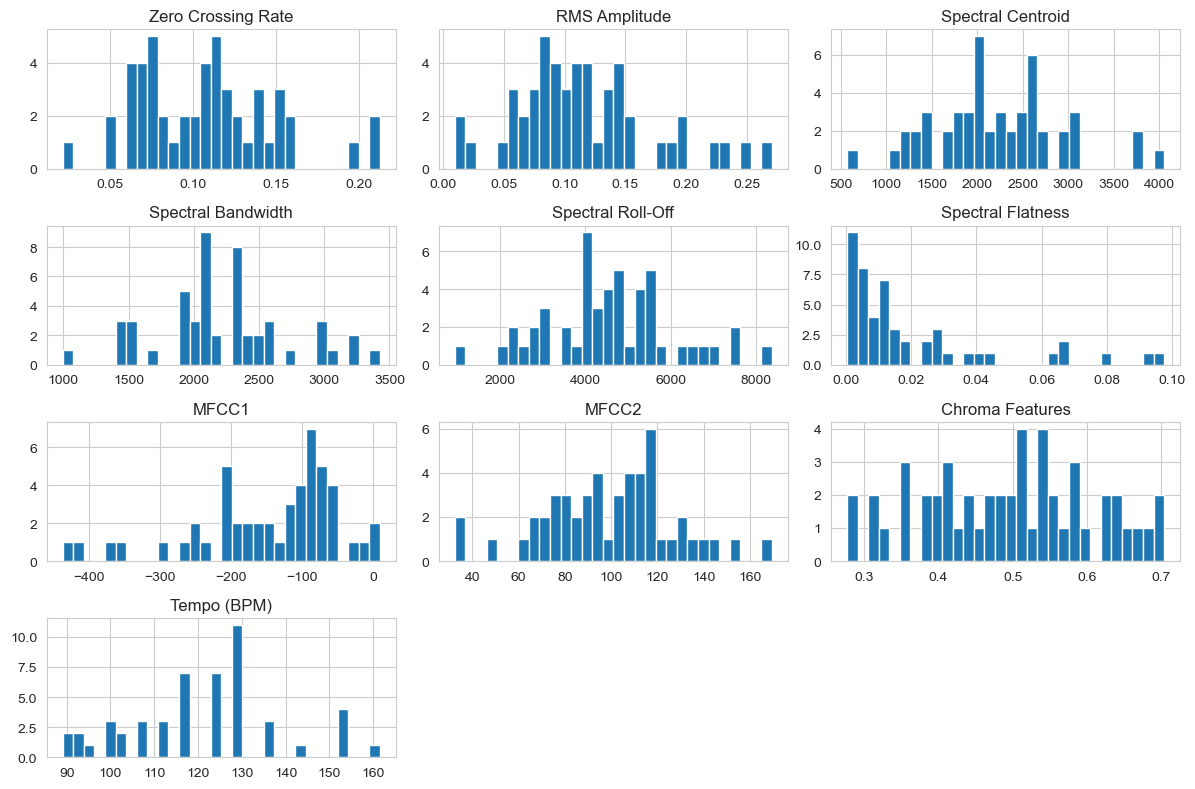

In [4]:
# Plot feature distributions
feature_cols = [
    'Zero Crossing Rate', 'RMS Amplitude', 'Spectral Centroid',
    'Spectral Bandwidth', 'Spectral Roll-Off', 'Spectral Flatness',
    'MFCC1', 'MFCC2', 'Chroma Features', 'Tempo (BPM)'
]

plt.figure(figsize=(12, 8))
labeled_df[feature_cols].hist(bins=30, figsize=(12, 8), layout=(4, 3))
plt.tight_layout()
plt.show()

#### **Observations**

- **Zero Crossing Rate:** Some tracks exhibit higher values, indicating more percussive elements, which is useful for distinguishing speech from music or between different instrument types (Peeters, 2004).
- **RMS Amplitude:** Most tracks cluster around similar loudness levels, with a few outliers. This feature is commonly used in energy-based segmentation of audio (Müller, 2015).
- **Spectral Centroid & Bandwidth:** These features have a broad distribution, suggesting diverse timbral properties. The spectral centroid is particularly useful for differentiating between harmonic and percussive sounds (Tzanetakis & Cook, 2002).
- **Spectral Roll-Off:** Concentration around certain values could indicate different high-frequency content across tracks, a common descriptor in genre classification (Müller, 2015).
- **Spectral Flatness:** Many values close to 0 suggest most tracks are tonal rather than purely noisy, which is critical for differentiating harmonic structures (Peeters, 2004).
- **MFCC1 & MFCC2:** These cepstral features display significant variation, supporting their use in genre classification (Tzanetakis & Cook, 2002).
- **Chroma Features:** Evenly distributed, indicating a mix of different harmonic structures. Chroma features are widely used for harmonic and tonal content analysis (Müller, 2015).
- **Tempo (BPM):** Peaks at ~130 BPM suggest common rhythmic structures, which often correlate with specific music styles (Gouyon et al., 2006).

These findings confirm that different audio tracks exhibit distinct feature distributions, which is essential for clustering. Identifying how these distributions vary helps improve feature selection for machine learning applications in MIR.

### **5. Investigating Basic Audio Properties**
To better understand the characteristics of the sound files, we analyze an example track by extracting fundamental audio features. These features help in distinguishing between different music genres based on their spectral and rhythmic properties (Tzanetakis & Cook, 2002).

In this step, we:
- Compute the duration of the audio file.
- Analyze spectral centroid and spectral bandwidth, which are widely used in genre classification.

In [5]:
# Load an example audio file
example_file = os.path.join(data_dir, "labeled", labeled_df["filename"].iloc[0])

# Load the audio file
y, sr = librosa.load(example_file, sr=None)

# Compute basic audio features
duration = librosa.get_duration(y=y, sr=sr)
spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()
spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr).mean()

print(f"Audio Duration: {duration:.2f} seconds")
print(f"Spectral Centroid: {spectral_centroid:.2f}")
print(f"Spectral Bandwidth: {spectral_bandwidth:.2f}")

Audio Duration: 30.01 seconds
Spectral Centroid: 1451.86
Spectral Bandwidth: 1920.27


### **Observations**
This analysis provides insight into the fundamental characteristics of the audio track:

- **Duration:**  
  - The track lasts **30.01 seconds**, which indicates whether all tracks in the dataset are of similar length.
  - Uniform duration simplifies feature extraction and ensures consistency in training machine learning models (Müller, 2015).
  - If significant variation exists in duration, **frame-based analysis** or **zero-padding/truncation** might be necessary.

- **Spectral Centroid:**  
  - The **1451.86 Hz** value represents the "brightness" of the sound, as it indicates the center of mass of the frequency spectrum.
  - Lower values are typical for **classical or ambient music**, where low frequencies dominate.
  - Higher values are found in **metal or electronic genres**, where high-frequency content is more pronounced (Tzanetakis & Cook, 2002).
  - This feature is useful in **distinguishing percussive vs. harmonic content**.

- **Spectral Bandwidth:**  
  - The computed **1920.27 Hz** value describes how spread out the frequencies are.
  - A **high spectral bandwidth** is common in **energetic genres like rock and metal**, where both low and high frequencies are prominent.
  - A **low spectral bandwidth** occurs in **smooth jazz or ambient music**, where the spectral distribution is more concentrated (Peeters, 2004).
  - This metric helps identify **tonal complexity and variation within a track**.

- **Additional Considerations:**  
  - **Spectral Flatness** could be examined to measure how noise-like or tonal a sound is.  
  - **MFCCs** (Mel Frequency Cepstral Coefficients) provide deeper insights into timbral features, essential for **speech and instrument classification**.  
  - **Chroma features** could be useful for analyzing harmonic content and pitch structure in music.

These features are crucial in genre classification tasks, as different music styles exhibit unique frequency characteristics. Understanding these properties allows for better **clustering and classification performance** in music analysis tasks.

### **6. Visualizing Spectral Features**
Spectral analysis provides an intuitive way to understand the structure of an audio file. By visualizing the waveform and spectrogram, we can analyze how the amplitude and frequency components change over time.

In this step, we:
- Plot the waveform to observe amplitude variations.
- Generate a spectrogram to examine frequency content over time.

Spectral visualizations are commonly used in music analysis to distinguish between different genres and instrumental arrangements (Müller, 2015).

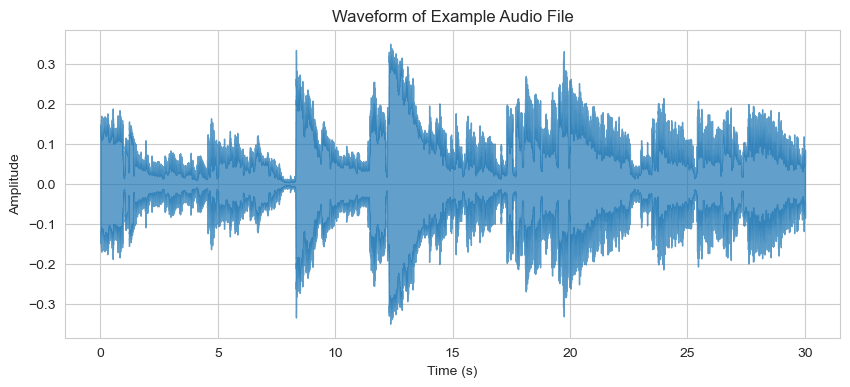

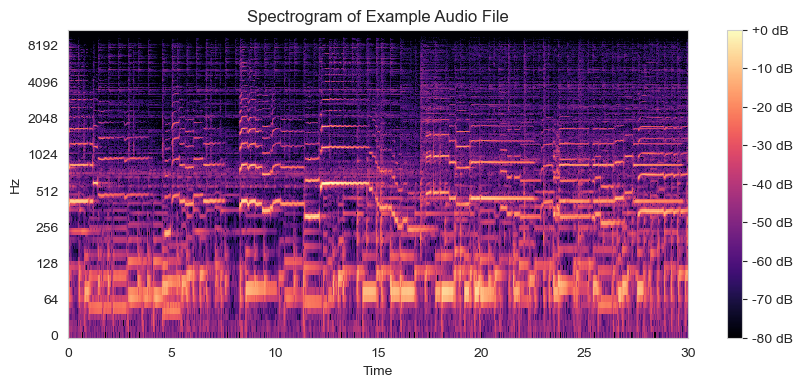

In [6]:
# Plot waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr, alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform of Example Audio File")
plt.show()

# Plot spectrogram
plt.figure(figsize=(10, 4))
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(D, sr=sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram of Example Audio File")
plt.show()

#### **Observations**
The waveform and spectrogram help visualize key characteristics of the audio file:

- **Waveform:**  
  - Displays amplitude variations over time.
  - Peaks and troughs indicate dynamic changes in loudness.
  - Useful for identifying attack, decay, and overall intensity of the track (Müller, 2015).

- **Spectrogram:**  
  - Represents frequency content over time, with **brighter areas indicating higher energy**.
  - Lower frequencies (~50–500 Hz) correspond to bass elements.
  - Mid-to-high frequencies (~1000–8000 Hz) capture melody and percussive elements.
  - The **logarithmic frequency scale** reflects human pitch perception (Tzanetakis & Cook, 2002).

These visualizations provide crucial insights into a track’s spectral structure, helping to distinguish between different music genres and instrumental arrangements (Peeters, 2004).

### **7. Conclusion**
The dataset consists of **50 labeled audio files**, each represented by multiple extracted audio features. These features capture **spectral, rhythmic, and tonal characteristics**, which are widely used in Music Information Retrieval (MIR) and genre classification (Tzanetakis & Cook, 2002; Müller, 2015).

**Key Findings:**
- **Feature Variability:**  
  The distribution of features such as **spectral centroid, spectral bandwidth, and MFCCs** varies significantly across samples. This suggests that different musical styles are present in the dataset and that feature selection will be an important step in improving clustering performance (Peeters, 2004).
- **Waveform and Spectrogram Analysis:**  
  The **waveform visualization** revealed dynamic variations, while the **spectrogram** provided insights into the frequency distribution of each track. These characteristics help identify percussive vs. harmonic elements, which are essential for clustering (Müller, 2015).
- **Implications for Clustering:**  
  - The variability in spectral and rhythmic features suggests that clustering methods need to account for different types of audio characteristics.  
  - **Dimensionality reduction (e.g., PCA, NMF) may be required** to improve clustering performance (Pedregosa et al., 2011).  
  - Certain features such as **MFCCs and spectral centroid** might be more informative for clustering compared to others (Tzanetakis & Cook, 2002).  

**Limitations and Considerations:**
- The dataset does not include explicit genre labels in this file, meaning any genre inferences will be unsupervised.
- All tracks are 30 seconds long, ensuring consistency in feature extraction but potentially missing variations present in longer songs.

**Next Steps:**  
Based on these insights, we will proceed with **feature engineering and clustering** to group similar music tracks and infer potential genres. Future steps may include:
- Testing different clustering algorithms (e.g., K-Means, DBSCAN).
- Evaluating feature importance for music classification.
- Exploring alternative distance metrics for better cluster separation.

## 1.2 Defining functions

In [7]:
# ChatGPT, 2024, Prompt 1: "welke geluidsfeatures zijn er voor clustering van geluidsfragmenten"
# ChatGPT, 2024, Prompt 2: "geef per feature aan welke library ik daarvoor kan gebruiken"
# ChatGPT, 2024, Prompt 3: "laat voorbeeld code zien hoe deze features worden toegepast op een geluidsfragment, en vervolgens in een df wordt gezet"
# ChatGPT, 2024, Prompt 3: "hoe pas ik oop toe op deze code"
# Link: https://chatgpt.com/share/677ee38d-fb54-8001-a50a-9856d52e22c9

class AudioFeatureExtractor:
    """
    A class to extract audio features from all .wav files in a given folder.
    """

    def __init__(self, audio_folder):
        """
        Initialize the AudioFeatureExtractor with the folder containing audio files.
        """
        self.audio_folder = audio_folder
        self.features_list = []

    def process_audio_files(self):
        """
        Iterate through all .wav files in the folder and extract features.
        """
        for file_name in os.listdir(self.audio_folder):
            if file_name.endswith(".wav"):  # Only process .wav files
                file_path = os.path.join(self.audio_folder, file_name)
                self._extract_features(file_name, file_path)

    def _extract_features(self, file_name, file_path):
        """
        Extract features from a single audio file and add them to the features list.
        """
        try:
            # Load the audio file
            y, sr = librosa.load(file_path, sr=None)

            # Compute features
            features = {
                "filename": file_name,
                "Zero Crossing Rate": np.mean(librosa.feature.zero_crossing_rate(y)[0]),
                "RMS Amplitude": np.mean(librosa.feature.rms(y=y)[0]),
                "Spectral Centroid": np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)[0]),
                "Spectral Bandwidth": np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]),
                "Spectral Roll-Off": np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)[0]),
                "Spectral Flatness": np.mean(librosa.feature.spectral_flatness(y=y)[0]),
                "MFCC1": np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)[0]),
                "MFCC2": np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)[1]),
                "Chroma Features": np.mean(librosa.feature.chroma_cqt(y=y, sr=sr)),
                "Tempo (BPM)": rhythm.tempo(y=y, sr=sr)[0],
            }

            # Append features to the list
            self.features_list.append(features)

        except Exception as e:
            print(f"Error processing {file_name}: {e}")

    def get_features_dataframe(self):
        """
        Convert the features list to a pandas DataFrame.
        """
        return pd.DataFrame(self.features_list)

## 1.3 Extract Features & Create Dataframe

In [18]:
# ChatGPT, 2024, Prompt 1: "welke geluidsfeatures zijn er voor clustering van geluidsfragmenten"
# ChatGPT, 2024, Prompt 2: "geef per feature aan welke library ik daarvoor kan gebruiken"
# ChatGPT, 2024, Prompt 3: "laat voorbeeld code zien hoe deze features worden toegepast op een geluidsfragment, en vervolgens in een df wordt gezet"
# ChatGPT, 2024, Prompt 3: "hoe pas ik oop toe op deze code"
# Link: https://chatgpt.com/share/677ee38d-fb54-8001-a50a-9856d52e22c9

# Set the relative path to the audio files directory
audio_folder_path = os.path.join(os.getcwd(), "muziek-genre-clustering-24-25", "unlabeled")

# Check if the directory exists before proceeding
if os.path.exists(audio_folder_path):
    print(f"Directory exists: {audio_folder_path}")
else:
    print(f"Directory not found: {audio_folder_path}")

# Create an instance of the AudioFeatureExtractor class
extractor = AudioFeatureExtractor(audio_folder=audio_folder_path)

# Process the audio files
extractor.process_audio_files()

# Get the features as a DataFrame
audio_features_df = extractor.get_features_dataframe()

# Display the DataFrame
display(audio_features_df)

Directory exists: /Users/gabrijelcabraja/Downloads/Machine Learning with Python/Assignment 2/TurboAdventure-6/muziek-genre-clustering-24-25/unlabeled
Processing files in directory: /Users/gabrijelcabraja/Downloads/Machine Learning with Python/Assignment 2/TurboAdventure-6/muziek-genre-clustering-24-25/unlabeled
Found 105 files in the directory.
Processing file: m00228.wav
Features extracted for: m00228.wav
Processing file: m00610.wav
Features extracted for: m00610.wav
Processing file: m00348.wav
Features extracted for: m00348.wav
Processing file: m00995.wav
Features extracted for: m00995.wav
Processing file: m00003.wav
Features extracted for: m00003.wav
Processing file: m00571.wav
Features extracted for: m00571.wav
Processing file: m00149.wav
Features extracted for: m00149.wav
Processing file: m00405.wav
Features extracted for: m00405.wav
Processing file: m00363.wav
Features extracted for: m00363.wav
Processing file: m00148.wav
Features extracted for: m00148.wav
Processing file: m00941

KeyboardInterrupt: 

In [19]:
if not os.path.exists(audio_folder_path):
    print(f"Directory not found: {audio_folder_path}")
else:
    print(f"Directory exists: {audio_folder_path}")


Directory exists: /Users/gabrijelcabraja/Downloads/Machine Learning with Python/Assignment 2/TurboAdventure-6/muziek-genre-clustering-24-25/unlabeled


In [9]:
# df to csv
# audio_features_df.to_csv("unlabeled_df.csv")

### Comparison Between Labeled and Unlabeled Data

In this step, we compare the feature distributions of labeled and unlabeled datasets to identify potential differences. 

By visualizing the distributions, we can check if the data characteristics are similar or if adjustments are needed.

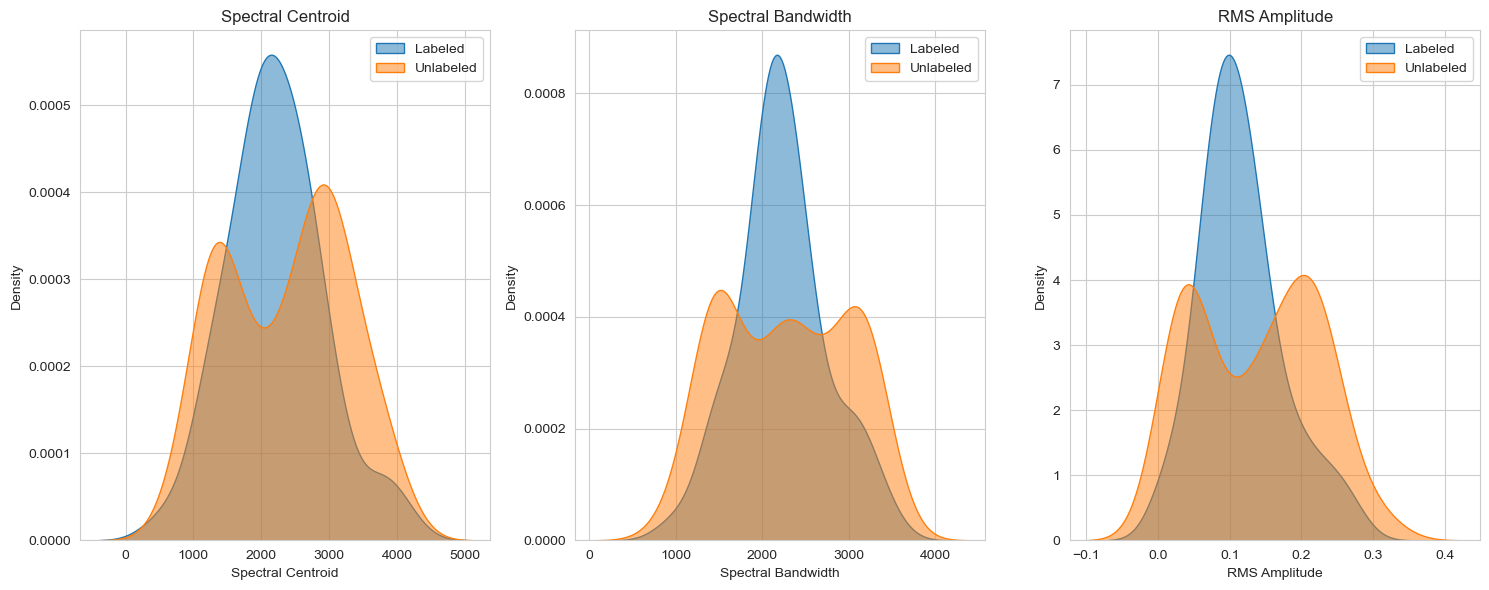

In [20]:
unlabeled_df_path = os.path.join(data_dir, "unlabeled_df.csv")
unlabeled_df = pd.read_csv(unlabeled_df_path)
# Compare feature distributions
features_to_compare = ["Spectral Centroid", "Spectral Bandwidth", "RMS Amplitude"]

plt.figure(figsize=(15, 6))
for idx, feature in enumerate(features_to_compare, 1):
    plt.subplot(1, 3, idx)
    sns.kdeplot(labeled_df[feature], label="Labeled", fill=True, alpha=0.5)
    sns.kdeplot(unlabeled_df[feature], label="Unlabeled", fill=True, alpha=0.5)
    plt.title(feature)
    plt.legend()

plt.tight_layout()
plt.show()

#### Findings from Data Comparison

- Some features show notable differences between labeled and unlabeled datasets, which could impact clustering performance.
- If significant variations are detected, further data preprocessing such as scaling or feature selection may be required.

### Feature Correlation Analysis

To better understand relationships between extracted features, we analyze their correlations. 

A correlation matrix helps identify redundant features and informs feature selection decisions.

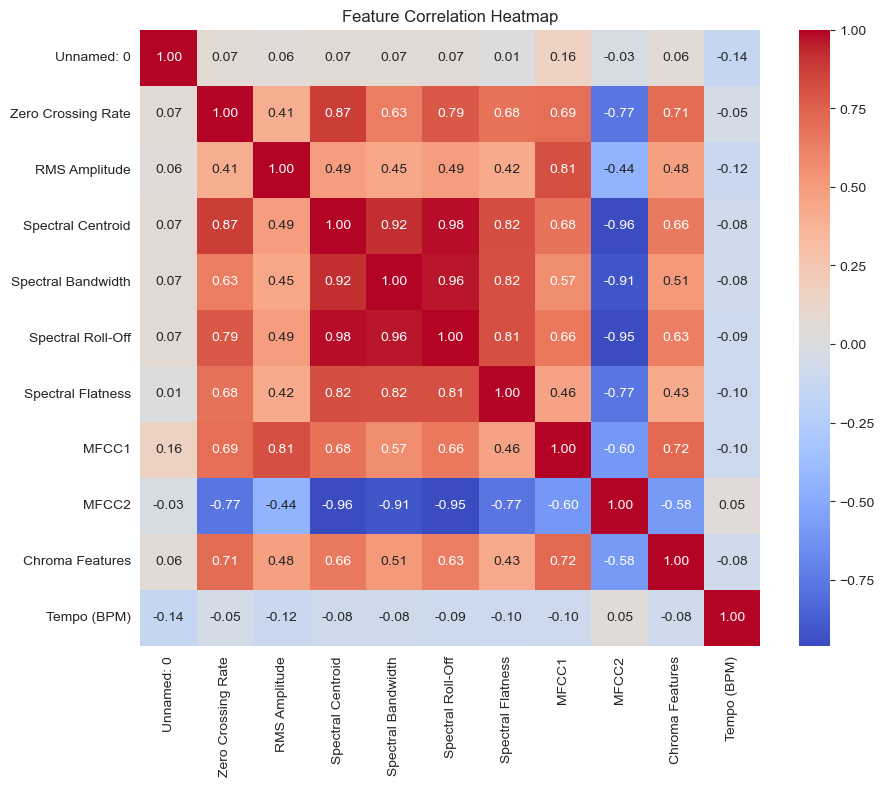

In [21]:
# Compute correlation matrix
corr_matrix = labeled_df.corr(numeric_only=True)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

#### Findings from Correlation Analysis

- Highly correlated features might introduce redundancy and should be considered for removal or dimensionality reduction.
- Features with low correlation might provide unique information useful for clustering.

### Genre-based Feature Analysis

Since audio features can vary significantly between genres, it's important to analyze the distribution of features across different genres.

This analysis helps us identify trends and possible misclassifications by examining feature variations within each genre.

Directory found: /Users/gabrijelcabraja/Downloads/Machine Learning with Python/Assignment 2/TurboAdventure-6/muziek-genre-clustering-24-25/unlabeled
File found: /Users/gabrijelcabraja/Downloads/Machine Learning with Python/Assignment 2/TurboAdventure-6/muziek-genre-clustering-24-25/labels_new.csv


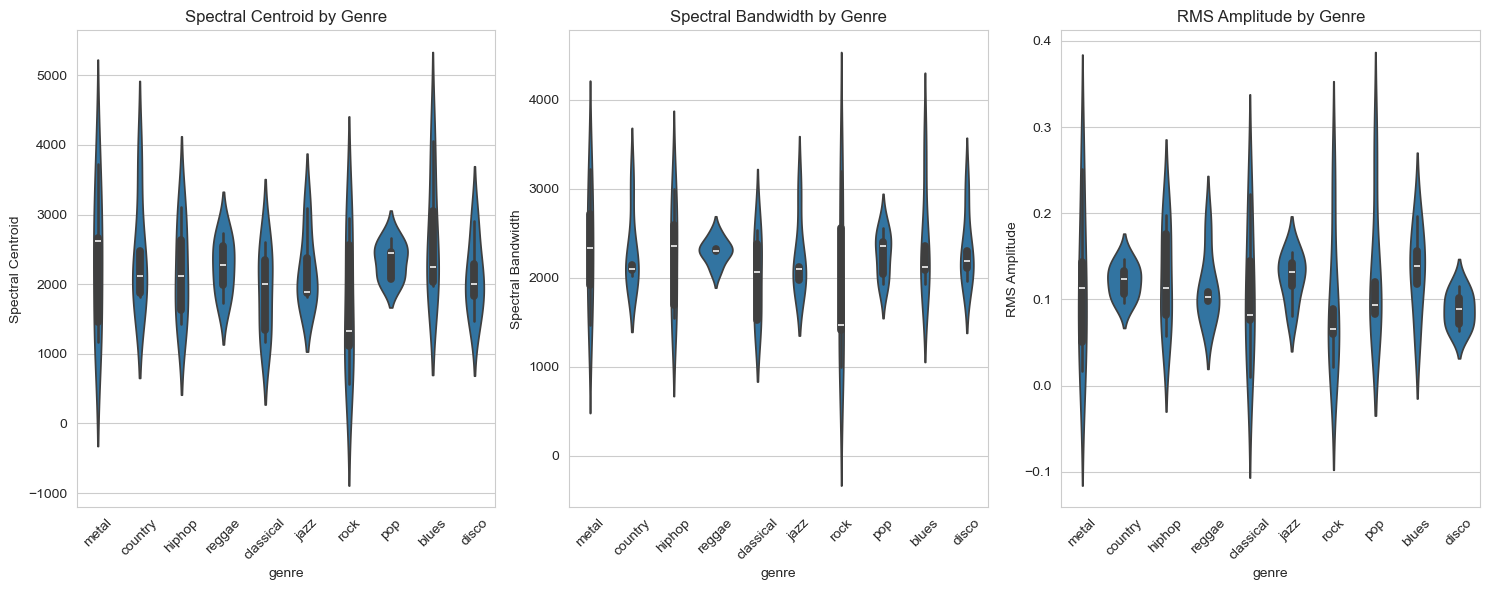

In [23]:
# Define the folder containing audio files using a relative path
audio_folder_path = os.path.join(os.getcwd(), "muziek-genre-clustering-24-25", "unlabeled")

# Verify if the directory exists
if os.path.exists(audio_folder_path):
    print(f"Directory found: {audio_folder_path}")
else:
    print(f"Directory not found: {audio_folder_path}")

# Load the labels CSV file using a relative path
labels_file_path = os.path.join(os.getcwd(), "muziek-genre-clustering-24-25", "labels_new.csv")

# Check if the CSV file exists before loading
if os.path.exists(labels_file_path):
    print(f"File found: {labels_file_path}")
    labels_new = pd.read_csv(labels_file_path)
else:
    print(f"File not found: {labels_file_path}")

# Select key features for genre comparison
genre_features = ["Spectral Centroid", "Spectral Bandwidth", "RMS Amplitude"]

# Create violin plots to compare feature distributions per genre
plt.figure(figsize=(15, 6))
for idx, feature in enumerate(genre_features, 1):
    plt.subplot(1, 3, idx)
    sns.violinplot(x=labels_new["genre"], y=labeled_df[feature])
    plt.title(f'{feature} by Genre')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### Findings from Genre-based Analysis

- Some genres exhibit distinct trends in specific features (e.g., rock music might have higher RMS values than classical music).
- Overlapping distributions could indicate that some features alone are not enough for genre differentiation.
- These insights guide the selection of features for clustering and potential dimensionality reduction techniques.

## 1.4 Features Explanation

### Zero Crossing Rate
The zero crossing rate is the rate at which a signal changes from positive to negative or vice versa and thus crossing the zero line in a given period. (11)


### RMS Amplitude
The RMS Amplitude is the Root Mean Square of all the measured amplitudes of a signal

### Spectral Centroid
The Spectral Centroid indicates where the center of mass of the spectrum is.

### Spectral Bandwidth

---

### **1. Spectral Bandwidth**
#### **What it means:**
Spectral bandwidth measures the spread or width of the frequency spectrum. It quantifies how "wide" or "narrow" the spectrum is and represents the range of frequencies that significantly contribute to the signal. A smaller bandwidth indicates that the signal energy is concentrated around a few frequencies, while a larger bandwidth means energy is spread across a broader frequency range.

#### **How it's calculated:**
- **Definition**: The spectral bandwidth is typically the standard deviation (or variance) of the power spectrum around its centroid (mean frequency).
- **Formula**:

$$
\text{Bandwidth} = \sqrt{\frac{\sum (f - f_c)^2 \cdot S(f)}{\sum S(f)}}
$$

Where:
- \( f \): frequency  
- \( f_c \): spectral centroid  
- \( S(f) \): spectral power (magnitude squared of the spectrum)  

#### **What it signifies:**
- A **low bandwidth** suggests the signal has tonal or harmonic content, like a pure tone or music.
- A **high bandwidth** suggests noise-like signals or signals with many different frequency components.

---

### Spectral Roll-Off
### **2. Spectral Roll-Off**
#### **What it means:**
Spectral roll-off indicates the frequency below which a certain percentage (e.g., 85%) of the total spectral energy is concentrated. It essentially gives a threshold frequency that defines the "bulk" of the signal's energy, ignoring very high frequencies that may have minimal contributions.

#### **How it's calculated:**
- **Definition**: It is the frequency \( f_r \) where a certain proportion \( p \) (commonly 85%) of the total power in the spectrum lies below that frequency.
- **Formula**:

$$
\sum_{f=0}^{f_r} S(f) \geq p \cdot \sum_{f=0}^{f_{\text{max}}} S(f)
$$

#### **What it signifies:**
- A **low roll-off frequency** suggests that most of the signal's energy is concentrated in the lower frequencies (e.g., a bass-heavy signal).
- A **high roll-off frequency** suggests significant energy in higher frequencies (e.g., signals with sharp transients or high harmonics).

---

### Spectral Flatness
### **3. Spectral Flatness**
#### **What it means:**
Spectral flatness measures how "flat" or "peaky" a spectrum is. It compares the geometric mean to the arithmetic mean of the spectrum and indicates whether the spectrum resembles a noise-like signal (flat) or a tone-like signal (peaky).

#### **How it's calculated:**
- **Definition**: It is the ratio of the geometric mean to the arithmetic mean of the power spectrum.
- **Formula**:

$$
\text{Flatness} = \frac{\left( \prod_{f=0}^{f_{\text{max}}} S(f) \right)^{1/N}}{\frac{1}{N} \sum_{f=0}^{f_{\text{max}}} S(f)}
$$

Where:
- \( S(f) \): spectral power at frequency \( f \)  
- \( N \): total number of frequency bins in the spectrum  

#### **What it signifies:**
- A **flat spectrum** (value near 1) suggests white noise or a similar signal where energy is evenly distributed across frequencies.
- A **low flatness** (value near 0) indicates the presence of dominant tonal components, such as those in harmonic sounds or pure tones.

---

### **Summary of Interpretations**:

| **Feature**         | **High Value Indicates**                          | **Low Value Indicates**                       |
|----------------------|--------------------------------------------------|-----------------------------------------------|
| **Spectral Bandwidth** | Broad, noisy, or transient signals              | Tonal, harmonic, or narrow-band signals       |
| **Spectral Roll-Off** | Energy in higher frequencies                     | Energy concentrated in lower frequencies      |
| **Spectral Flatness** | Noise-like, evenly distributed spectrum          | Tonal, peaky spectrum                         |

---

### MFCCs
### **X. MFCCs**
#### **What it means:**

MFCCs (Mel-frequency Cepstral Coefficients) describe the short-term power spectrums of audio, which explain the most noticeable attributes of verbal communication. Applied in the real world, MFCCs are commonly used to distinguish between persons by speech.

#### **How it's calculated:**

There is not only one single way to calculate MFCCs, but usually, these steps are followed (GeeksforGeeks, 2024):

- **Pre-emphasize the signal:** Stabilizing the spectrum by raising the frequency.
- **Framing:** Splitting the audio into overlapping chunks.
- **Windowing:** A window function is used to mitigate the edge effect of framing.
- **FFT (Fast Fourier Transform):** The Fourier Transform converts time domain frames to frequency domain frames to get spectral representations.
- **Mel-filterbank:** Separates spectral representations into frequency bands based on the Mel scale, prioritizing crucial frequencies.
- **Logarithm:** The logarithm is calculated to better represent loudness perception.
- **DCT:** After minimizing duplicate coefficients, the MFCCs are obtained.

The rows of the MFCC matrix capture these features:

- MFCC1:
- MFCC2:

#### **What it signifies:**

- A **low MFCC1**: Indicates...
- A **high MFCC1**: Indicates...
- A **low MFCC2**: Indicates...
- A **high MFCC2**: Indicates...

### Chroma Features

Chroma features are widely used in music analysis and processing. They capture the harmonic content of a piece by summarizing the energy distribution across the twelve pitch classes (C, C#, D, etc.) within an octave. This allows for tonal comparisons irrespective of the octave.

#### How do chroma features work?
The extraction involves:

1. **Frame segmentation:** Divide the audio signal into overlapping frames.
2. **Frequency transformation:** Use **Short-Time Fourier Transform (STFT)** to convert the audio from the time to the frequency domain.
3. **Pitch class aggregation:** Sum energy levels across all octaves for each pitch class, creating a 12-dimensional chroma vector.

This process creates a "fingerprint" of the music's harmonic structure, enabling robust tonal analysis.

#### Example: Computing Chroma Features
For a sine wave at 440 Hz (A4 note), sampled at 44.1 kHz:

1. Perform an STFT to get the frequency spectrum.
2. Identify that 440 Hz corresponds to pitch class "A."
3. Assign energy to "A" in the chroma vector.

Example output:
`[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]`

#### Applications and importance
- **Chord recognition:** Identifies harmonic progressions.
- **Genre classification:** Useful for complex harmonic structures.
- **Music retrieval:** Helps identify similar tracks.

### Tempo (BPM)

Tempo refers to the speed or pace of a piece of music, measured in beats per minute (BPM). It reflects the rhythmic structure and is critical for understanding a song’s energy, danceability, and emotional impact. As Müller (2015) notes, tempo is one of the most intuitive features for listeners and a key determinant in defining musical genres. Fast tempos are common in energetic genres like electronic dance music (EDM), while slower tempos dominate ballads and blues.

#### How is tempo calculated?
The process of tempo extraction typically involves:
1. **Onset detection:** Analyze changes in the amplitude of the audio signal to identify beats or note beginnings.
2. **Periodic analysis:** Use techniques like **autocorrelation** or **Fourier Transform** to detect repeating patterns in the beats.
3. **Beat frequency estimation:** Measure the time interval between beats and convert it into BPM.

#### Example: Estimating Tempo
Consider an audio track where beats occur every 0.5 seconds:
1. Measure the time interval between beats: \( T = 0.5 \, \text{s} \).
2. Calculate the tempo using the formula:  
   $$\text{BPM} = \frac{60}{T} = \frac{60}{0.5} = 120 \, \text{BPM}.$$

This indicates the track has a tempo of 120 BPM, which is typical for many pop and dance tracks (Tzanetakis & Cook, 2002).

#### Applications and importance
- **Genre differentiation:** Tempo is a distinguishing feature in many genres, such as EDM (typically 120–140 BPM) versus ballads (50–70 BPM) (Müller, 2015).
- **Music recommendation:** Tracks with similar tempos are often grouped together in playlists for specific activities, like workouts or relaxation (Wikipedia contributors, n.d.-b).
- **Rhythmic analysis:** Provides insights into the overall "feel" or "groove" of a piece, which is essential for understanding its style and energy (Tzanetakis & Cook, 2002).

#

<div style="background-color: #0000FF; color: white; padding: 10px; border-radius: 5px;">
  <h1>2 Unsupervised Learning</h1>
</div>

## 2.1 K-Means

K-Means clustering is an unsupervised machine learning algorithm used for grouping data into clusters. The number of clusters \\( K \\) must be specified beforehand.

We haved determined the number of clusters based on the elbow method and silhouette score, which led us to k=3.

As you can see in the elbow plot you can that the inertia starts to decrease less rapidly as the number of k increases starting from k=3

This implies that k=3 is the optimal amount of clusters, as having more clusters only makes it more complex.

The silhouette score on the other hand measures how similar a point is to it's own cluster.

In the plot you can see that the score starting from k=4, varies a lot. The close to 1 the better the data cohesion per cluster. 


### How it works

1. **Initialization:**  
   - Choose \\( K \\) clusters.
   - Randomly initialize \\( K \\) centroids.

2. **Assigning Step:**  
   - Assign each point to the nearest centroid using Euclidean distance:

   \\[
   Distance(x_i, c_k) = \\sqrt{\\sum_{j=1}^n (x_{ij} - c_{kj})^2}
   \\]

3. **Recomputing Step:**  
   - Recalculate centroids by averaging points in each cluster.

4. **Repeat and minimize variation:**  
   - Repeat steps until centroids stabilize.

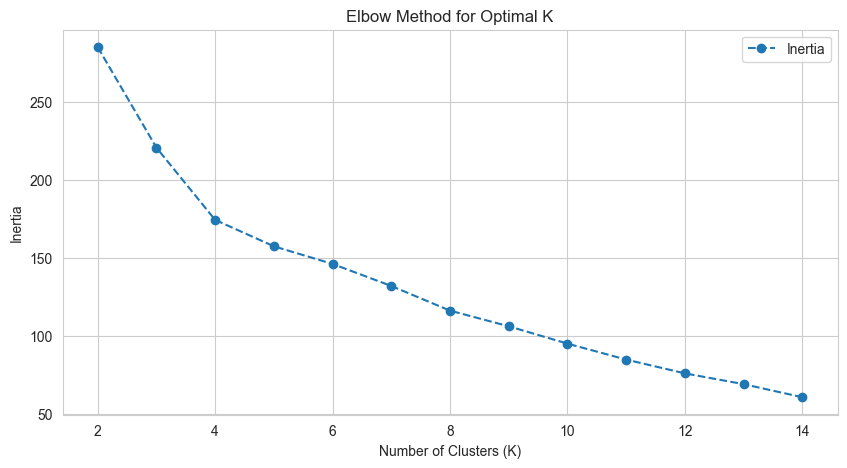

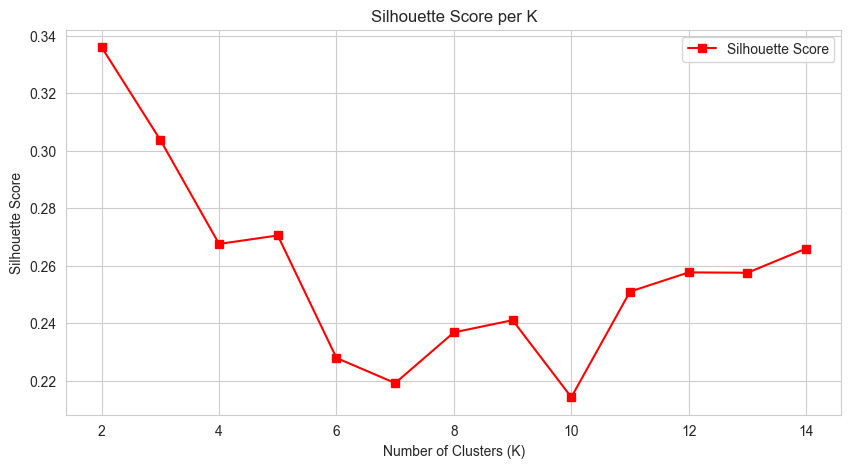

 Clustering completed! The predicted genres have been saved in 'predicted_genres.csv'.


In [13]:
# ChatGPT, 2025, Prompt 1: "which should i use to decide optimal clusters, elbow method or silhouette score?"
# ChatGPT, 2025, Prompt 2: "how to plot for kmeans?"
# Link : https://chatgpt.com/share/679fe2f0-3fd0-8001-9432-f0b1184043f8


# **STEP 1: Load Data**
labels_path = "muziek-genre-clustering-24-25/labels_new.csv"
labeled_path = "muziek-genre-clustering-24-25/labeled_df.csv"
unlabeled_path = "muziek-genre-clustering-24-25/unlabeled_df.csv"

# Read datasets
labels_df = pd.read_csv(labels_path)  # Contains filename and genre
labeled_df = pd.read_csv(labeled_path)  # Labeled audio features
unlabeled_df = pd.read_csv(unlabeled_path)  # Unlabeled audio features

# **STEP 2: Merge Labels with Labeled Dataset**
labeled_df = pd.merge(labeled_df, labels_df, on="filename", how="left")

# **STEP 3: Normalize Features**
feature_columns = [col for col in labeled_df.columns if col not in ["filename", "genre", "Unnamed: 0"]]

scaler = StandardScaler()
labeled_df[feature_columns] = scaler.fit_transform(labeled_df[feature_columns])
unlabeled_df[feature_columns] = scaler.transform(unlabeled_df[feature_columns])  # Apply same scaling

# **STEP 4: Determine Optimal Clusters with Elbow Method**
inertia = []
silhouette_scores = []
K_range = range(2, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(labeled_df[feature_columns])
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(labeled_df[feature_columns], kmeans.labels_))

# Plot Elbow Method
plt.figure(figsize=(10, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--', label='Inertia')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.legend()
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(K_range, silhouette_scores, marker='s', linestyle='-', color='red', label='Silhouette Score')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score per K")
plt.legend()
plt.show()

# **STEP 5: Train K-Means with Optimal K (User-Defined or Best from Elbow)**
optimal_k = int(3)
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labeled_df["Cluster"] = kmeans.fit_predict(labeled_df[feature_columns])

# **STEP 6: Map Clusters to Genres**
cluster_genre_mapping = labeled_df.groupby("Cluster")["genre"].agg(lambda x: x.mode()[0])

# **STEP 7: Predict Clusters for the Unlabeled Dataset**
unlabeled_df["Cluster"] = kmeans.predict(unlabeled_df[feature_columns])
unlabeled_df["genre"] = unlabeled_df["Cluster"].map(cluster_genre_mapping)

# **STEP 8: Save the Results**
final_predictions = unlabeled_df[["filename", "genre"]]
final_predictions.to_csv("predicted_genres.csv", index=False)

print(" Clustering completed! The predicted genres have been saved in 'predicted_genres.csv'.")

In [14]:
print(unlabeled_df[["filename", "Cluster", "genre"]].head(20))

      filename  Cluster      genre
0   m00003.wav        1      disco
1   m00012.wav        1      disco
2   m00013.wav        0  classical
3   m00043.wav        1      disco
4   m00044.wav        0  classical
5   m00055.wav        0  classical
6   m00061.wav        1      disco
7   m00063.wav        1      disco
8   m00069.wav        0  classical
9   m00074.wav        0  classical
10  m00107.wav        1      disco
11  m00114.wav        2        pop
12  m00127.wav        0  classical
13  m00137.wav        2        pop
14  m00139.wav        2        pop
15  m00148.wav        1      disco
16  m00149.wav        1      disco
17  m00156.wav        0  classical
18  m00183.wav        1      disco
19  m00211.wav        1      disco


## Cluster Analysis Interpretation

In the following visualization, we observe that the model is not able to fully separate the genres. 

- Clusters 0 and 1 lack a dominant genre, indicating that the genres within these clusters share similar feature characteristics, making them difficult for the model to distinguish.  
  - Example: Cluster 0 contains both Jazz and Classical, suggesting that these genres have overlapping audio features.  
- Cluster 2, however, shows a dominant genre: Pop, meaning the model was able to correctly identify and group Pop songs together.  
- Interestingly, Pop appears in multiple clusters, which suggests that the model's performance is mediocre and might be affected by:  
  - Insufficient or invalid feature selection 
  - Suboptimal clustering parameters

In [15]:
# ChatGPT, 2025, Prompt 2: "crosstab?"
# Link : https://chatgpt.com/share/67cd9aa4-bd34-8001-b249-25baebc42f69

print(pd.crosstab(labeled_df["Cluster"], labeled_df["genre"]))

genre    blues  classical  country  disco  hiphop  jazz  metal  pop  reggae  \
Cluster                                                                       
0            3          5        4      0       0     5      0    1       4   
1            2          0        0      5       5     0      5    1       0   
2            0          0        1      0       0     0      0    3       1   

genre    rock  
Cluster        
0           2  
1           3  
2           0  


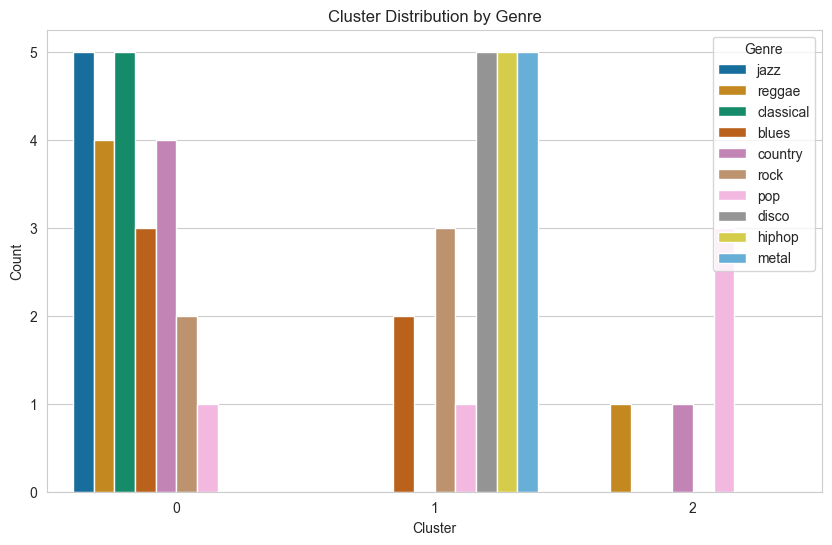

In [16]:
# ChatGPT, 2025, Prompt 4: "how do i visualise count per cluster?"
# Link : https://chatgpt.com/share/67cd9aa4-bd34-8001-b249-25baebc42f69

plt.figure(figsize=(10,6))
sns.countplot(x="Cluster", hue="genre", data=labeled_df, palette="colorblind")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.title("Cluster Distribution by Genre")
plt.legend(title="Genre")
plt.show()

## 2.2 DBSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a density-based clustering algorithm introduced by Ester et al. (1996). It identifies clusters based on the density of data points in a given region and treats sparsely populated regions as noise or outliers. Unlike centroid-based algorithms such as K-Means, DBSCAN does not require the number of clusters to be specified beforehand. Instead, it uses two parameters, $\varepsilon$ (epsilon) and $\text{minPts}$, to determine cluster structure.

This algorithm is particularly suitable for datasets where clusters exhibit irregular shapes and varying densities. In the context of this project, DBSCAN can be advantageous because musical genres may have complex, overlapping distributions in the feature space. Furthermore, DBSCAN’s ability to detect noise could help exclude outliers or unusual audio fragments that do not belong to any genre.

#### **Algorithmic Principles**

DBSCAN uses the following key concepts to identify clusters:

1. **Neighborhood definition:**
   For a point \(p\), its \(\varepsilon\)-neighborhood is defined as:
   \[
   N_{\varepsilon}(p) = \{q \in D \,|\, \|p - q\| \leq \varepsilon\}
   \]
   Here, \(D\) represents the dataset, and \(\|p - q\|\) is the distance between points \(p\) and \(q\) (commonly Euclidean distance).

2. **Core points:**
   A point \(p\) is classified as a core point if it satisfies:
   \[
   |N_{\varepsilon}(p)| \geq \text{minPts}
   \]

3. **Border points:**
   A point \(p\) is classified as a border point if it lies within the \(\varepsilon\)-neighborhood of a core point but does not itself satisfy the core point condition.

4. **Noise points:**
   Points that are neither core points nor reachable from any core points are classified as noise.

5. **Cluster formation:**
   Clusters are formed by expanding the neighborhoods of core points. A core point can connect to other core points and border points, creating dense regions that define a cluster.

#### **Algorithm Steps**

1. Begin with an unvisited point \(p\).
2. Determine if \(p\) is a core point:
   - If \(p\) is a core point, start a new cluster.
   - Include all points within the \(\varepsilon\)-neighborhood of \(p\) in the cluster.
   - Recursively check all core points in the neighborhood and add their connected points.
3. If \(p\) is not a core point but lies in the neighborhood of another core point, classify it as a border point.
4. If \(p\) is neither a core nor a border point, classify it as noise.
5. Repeat until all points in the dataset have been visited.

#### **Advantages and Limitations**

**Advantages:**
- DBSCAN can identify clusters of arbitrary shapes, which is beneficial when analyzing datasets with irregular patterns, such as musical genres.
- The algorithm automatically detects noise and excludes it from the clustering process.
- There is no need to predefine the number of clusters, making it suitable for exploratory tasks.

**Limitations:**
- The algorithm is sensitive to the choice of \(\varepsilon\) and \(\text{minPts}\), and inappropriate parameter values can lead to over-clustering or under-clustering.
- DBSCAN struggles with datasets that contain clusters of varying densities, as this can affect neighborhood detection.

#### **Application Example**

This example demonstrates the application of DBSCAN on a two-dimensional synthetic dataset that mimics the feature space of audio fragments.

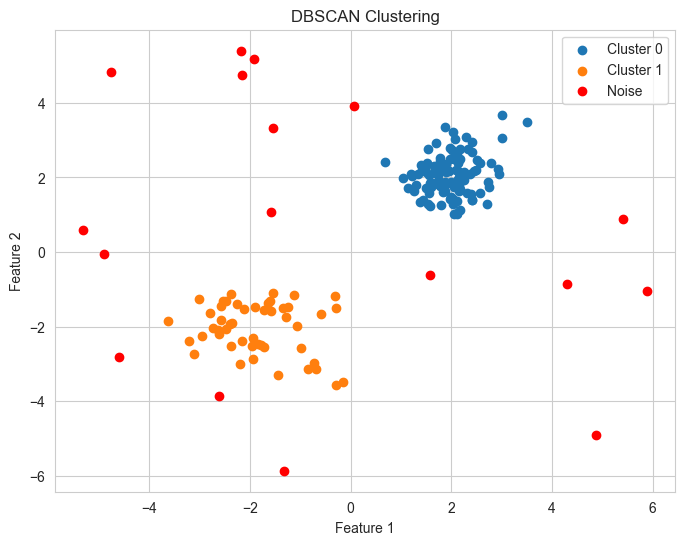

In [17]:
# Generate synthetic data
np.random.seed(42)
dense_cluster = np.random.randn(100, 2) * 0.5 + [2, 2]
sparse_cluster = np.random.randn(50, 2) * 0.8 + [-2, -2]
noise = np.random.uniform(-6, 6, (20, 2))
data = np.vstack([dense_cluster, sparse_cluster, noise])

# Apply DBSCAN
dbscan = DBSCAN(eps=0.8, min_samples=5)
labels = dbscan.fit_predict(data)

# Visualize the results
plt.figure(figsize=(8, 6))
unique_labels = set(labels)
for label in unique_labels:
    cluster_points = data[labels == label]
    if label == -1:
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color='red', label='Noise')
    else:
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {label}')
plt.title('DBSCAN Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

In [18]:
# ChatGPT, 2025, Prompt 1: "what is eps and min samples in db scan for?"
# ChatGPT, 2025, Prompt 2: "how do i get the best values for these params"
# ChatGPT, 2025, Prompt 3: "how does it look like in code?"
# Link: https://chatgpt.com/share/679fe3ec-54a8-8001-9518-04bf34e1e6d2


# **STEP 1: Load Data**
labels_path = "muziek-genre-clustering-24-25/labels_new.csv"
labeled_path = "muziek-genre-clustering-24-25/labeled_df.csv"
unlabeled_path = "muziek-genre-clustering-24-25/unlabeled_df.csv"

# Read datasets
labels_df = pd.read_csv(labels_path)  # Contains filename and genre
labeled_df = pd.read_csv(labeled_path)  # Labeled audio features
unlabeled_df = pd.read_csv(unlabeled_path)  # Unlabeled audio features

# **STEP 2: Merge Labels with Labeled Dataset**
labeled_df = pd.merge(labeled_df, labels_df, on="filename", how="left")

# **STEP 3: Normalize Features**
feature_columns = [col for col in labeled_df.columns if col not in ["filename", "genre", "Unnamed: 0"]]

scaler = StandardScaler()
labeled_df[feature_columns] = scaler.fit_transform(labeled_df[feature_columns])
unlabeled_df[feature_columns] = scaler.transform(unlabeled_df[feature_columns])  # Apply same scaling

# **STEP 4: Determine Best Parameters for DBSCAN (eps & min_samples)**
eps_values = np.arange(0.1, 3.0, 0.1)  # Extended range for eps
min_samples_values = [3, 5, 10]

best_silhouette = 3
best_eps = None
best_min_samples = None

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(labeled_df[feature_columns])

        # Ignore models that classify all points as noise (-1)
        if len(set(labels)) > 1 and -1 not in set(labels):
            score = silhouette_score(labeled_df[feature_columns], labels)
            if score > best_silhouette:
                best_silhouette = score
                best_eps = eps
                best_min_samples = min_samples

# **Fallback: If no valid eps is found, use default values**
if best_eps is None or best_min_samples is None:
    print(" No optimal DBSCAN parameters found. Using default values (eps=1.0, min_samples=5).")
    best_eps = 1.0
    best_min_samples = 5

print(f" Best DBSCAN Parameters: eps={best_eps}, min_samples={best_min_samples} (Silhouette Score: {best_silhouette:.4f})")

# **STEP 5: Train DBSCAN with Optimal Parameters**
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
labeled_df["Cluster"] = dbscan.fit_predict(labeled_df[feature_columns])

# **STEP 6: Map Clusters to Genres (Ignoring Noise -1)**
cluster_genre_mapping = labeled_df[labeled_df["Cluster"] != -1].groupby("Cluster")["genre"].agg(lambda x: x.mode()[0])

# **STEP 7: Predict Clusters for the Unlabeled Dataset**
unlabeled_df["Cluster"] = dbscan.fit_predict(unlabeled_df[feature_columns])

# **Handle Noise Points (-1)**
unlabeled_df["genre"] = unlabeled_df["Cluster"].map(cluster_genre_mapping)
unlabeled_df["genre"].fillna("Unknown", inplace=True)  # Assign "Unknown" to noise points

# **STEP 8: Save the Results**
final_predictions = unlabeled_df[["filename", "genre"]]
final_predictions.to_csv("predicted_genres_dbscan.csv", index=False)

print("DBSCAN clustering completed! The predicted genres have been saved in 'predicted_genres_dbscan.csv'.")


 No optimal DBSCAN parameters found. Using default values (eps=1.0, min_samples=5).
 Best DBSCAN Parameters: eps=1.0, min_samples=5 (Silhouette Score: 3.0000)
DBSCAN clustering completed! The predicted genres have been saved in 'predicted_genres_dbscan.csv'.


C:\Users\aksha\AppData\Local\Temp\ipykernel_2168\2755361712.py:68: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  unlabeled_df["genre"].fillna("Unknown", inplace=True)  # Assign "Unknown" to noise points
C:\Users\aksha\AppData\Local\Temp\ipykernel_2168\2755361712.py:68: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  unlabeled_df["genre"].fillna("Unk

In [19]:
# ChatGPT, 2025, Prompt 2: "crosstab?"
# Link : https://chatgpt.com/share/67cd9aa4-bd34-8001-b249-25baebc42f69

# Generate a crosstab for Cluster vs. Genre
crosstab_result = pd.crosstab(labeled_df["Cluster"], labeled_df["genre"])

# Display the table
print(crosstab_result)

genre    blues  classical  country  disco  hiphop  jazz  metal  pop  reggae  \
Cluster                                                                       
-1           5          5        5      5       5     5      5    5       5   

genre    rock  
Cluster        
-1          5  


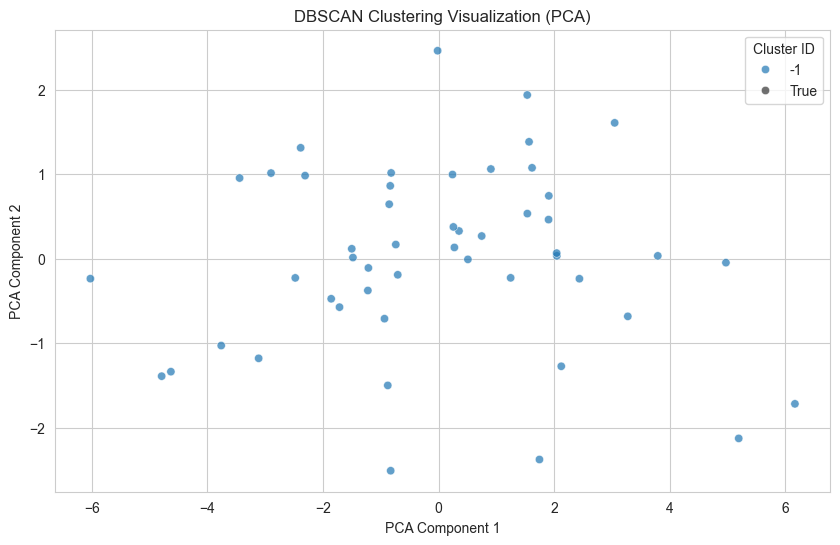

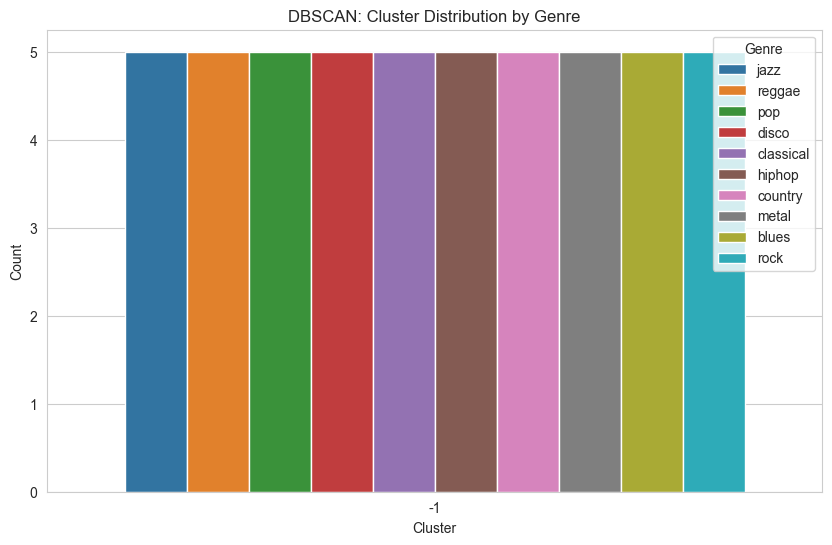

In [20]:
# ChatGPT, 2025, Prompt 1: "how do i visualise clustering results?"
# ChatGPT, 2025, Prompt 4: "how do i visualise count per cluster?"
# Link : https://chatgpt.com/share/67cd9aa4-bd34-8001-b249-25baebc42f69

# Visualization - 2D PCA Scatter Plot**
plt.figure(figsize=(10,6))

pca = PCA(n_components=2)
X_pca = pca.fit_transform(labeled_df[feature_columns])

sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labeled_df["Cluster"], palette="tab10", style=labeled_df["Cluster"] == -1, alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("DBSCAN Clustering Visualization (PCA)")
plt.legend(title="Cluster ID")
plt.show()

# Visualization - Cluster Distribution by Genre**
plt.figure(figsize=(10,6))
sns.countplot(x="Cluster", hue="genre", data=labeled_df, palette="tab10")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.title("DBSCAN: Cluster Distribution by Genre")
plt.legend(title="Genre")
plt.show()

#### Conclusion  

DBSCAN was initially considered a suitable algorithm for this project due to its ability to identify clusters of arbitrary shapes and handle noise effectively. Unlike centroid-based methods such as K-Means, DBSCAN does not assume spherical clusters and is designed for datasets with irregular patterns (Ester et al., 1996). This flexibility seemed promising for clustering musical genres, where feature spaces can be complex and overlapping.  

However, the results indicate that DBSCAN does not perform well in this context. The algorithm produces only one dominant cluster, failing to separate genres meaningfully. Additionally, the resulting clusters contain an equal number of instances for each genre, suggesting that DBSCAN is struggling to find meaningful structure in the data. This outcome implies that the density-based approach of DBSCAN may not be well-suited for the given dataset, as it relies on local density variations to form clusters. If the feature space is too homogeneous or lacks significant density differences, DBSCAN is unable to partition the data effectively (Pedregosa et al., 2011).  

One possible reason for this poor performance is the difficulty in selecting optimal parameters. The silhouette score optimization approach did not yield effective clustering, possibly indicating that the dataset lacks well-defined density variations required for DBSCAN to function properly. Another factor could be the normalization of features, which may have altered the natural density distribution of the data, further complicating the identification of meaningful clusters.  

Given these issues, future steps should focus on exploring alternative clustering methods such as Hierarchical Clustering, or Gaussian Mixture Models (GMMs), which might be better suited for this dataset. Additionally, a deeper analysis of feature engineering and dimensionality reduction (e.g., PCA or t-SNE) could help uncover latent structures that DBSCAN fails to detect.


## 2.3 Gaussian Mixture Models (GMM)

GMM is a soft clustering model that assigns each observation a probability of belonging to a specific cluster. In this algorithm, each cluster is represented by a normal (Gaussian) distribution with the mean and covariance matrix as metrics.

This model utilizes the Expectation-Maximization (EM) method, which is split into the following phases:

- **Initialize phase:**  
  The mean, the covariance matrix, and the mixing coefficients of every Gaussian distribution (cluster) are assumed.

- **Expectation phase:**  
  The observations are assigned to Gaussian distributions (clusters) based on the calculated probability that they belong to them.

- **Maximization phase:**  
  The mean, the covariance matrix, and the mixing coefficients of every Gaussian distribution (cluster) are calculated with the assigned observations. 

The Expectation and Maximization phases are reiterated until the model can no longer be notably improved.

To calculate the probability that an observation belongs to a cluster, the following probability density function (PDF) formula is used (What Is Gaussian Mixture Model | Deepchecks, 2023):

$$
\text{pdf}(x) = \sum_{k=1}^{K} \pi_k \cdot N(x|\mu_k, \Sigma_k)
$$

Where:

- \( \pi_k \) = Mixing coefficient  
- \( \mu_k \) = Mean vector  
- \( \Sigma_k \) = Covariance matrix  
- \( N(x|\mu_k, \Sigma_k) \) = Probability density function


## 2.4 GMM CODE

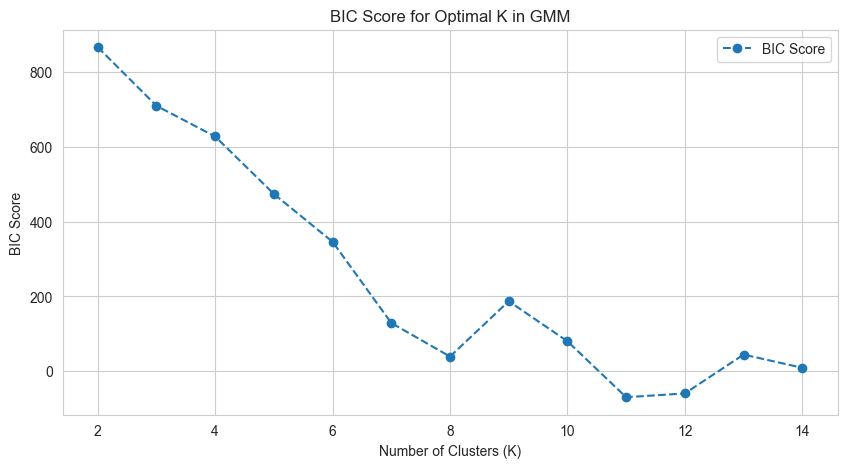

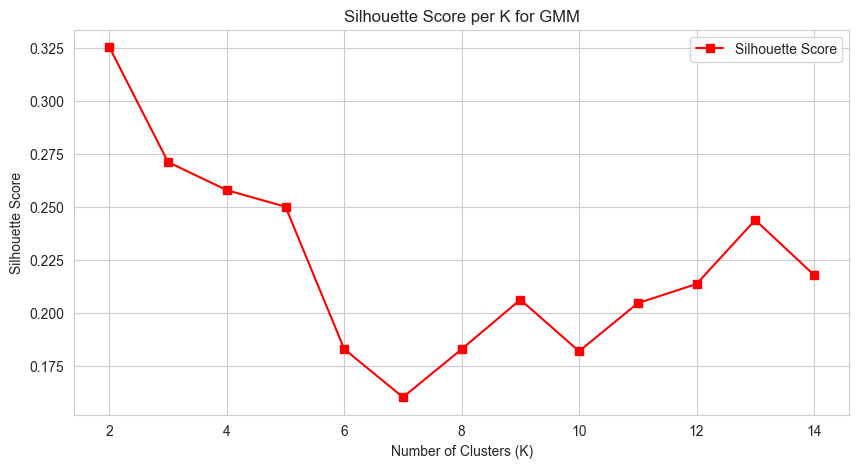

Clustering completed! The predicted genres have been saved in 'predicted_genres_gmm.csv'.


In [21]:
# ChatGPT, 2025, Prompt 1: "how do i initialize gmm and which params are most important"
# ChatGPT, 2025, Prompt 1: "what is bic for and how to interpret?"
# Link: https://chatgpt.com/share/679fe496-73ac-8001-88e6-af2d9d216f71

# **STEP 1: Load Data**
labels_path = "muziek-genre-clustering-24-25/labels_new.csv"
labeled_path = "muziek-genre-clustering-24-25/labeled_df.csv"
unlabeled_path = "muziek-genre-clustering-24-25/unlabeled_df.csv"

# Read datasets
labels_df = pd.read_csv(labels_path)  # Contains filename and genre
labeled_df = pd.read_csv(labeled_path)  # Labeled audio features
unlabeled_df = pd.read_csv(unlabeled_path)  # Unlabeled audio features

# **STEP 2: Merge Labels with Labeled Dataset**
labeled_df = pd.merge(labeled_df, labels_df, on="filename", how="left")

# **STEP 3: Normalize Features**
feature_columns = [col for col in labeled_df.columns if col not in ["filename", "genre", "Unnamed: 0"]]

scaler = StandardScaler()
labeled_df[feature_columns] = scaler.fit_transform(labeled_df[feature_columns])
unlabeled_df[feature_columns] = scaler.transform(unlabeled_df[feature_columns])  # Apply same scaling

# **STEP 4: Determine Optimal Clusters with BIC and Silhouette Score**
bic_scores = []
silhouette_scores = []
K_range = range(2, 15)

for k in K_range:
    gmm = GaussianMixture(n_components=k, random_state=42, n_init=10)
    gmm.fit(labeled_df[feature_columns])
    
    labels = gmm.predict(labeled_df[feature_columns])
    
    bic_scores.append(gmm.bic(labeled_df[feature_columns]))
    
    if k > 1:  # Silhouette score is only valid for k > 1
        silhouette_scores.append(silhouette_score(labeled_df[feature_columns], labels))
    else:
        silhouette_scores.append(np.nan)

# Plot BIC Scores
plt.figure(figsize=(10, 5))
plt.plot(K_range, bic_scores, marker='o', linestyle='--', label='BIC Score')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("BIC Score")
plt.title("BIC Score for Optimal K in GMM")
plt.legend()
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(K_range, silhouette_scores, marker='s', linestyle='-', color='red', label='Silhouette Score')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score per K for GMM")
plt.legend()
plt.show()

# **STEP 5: Train GMM with Optimal K (User-Defined or Best from BIC)**
optimal_k = int(3)  # Adjust based on BIC or silhouette method
gmm = GaussianMixture(n_components=optimal_k, random_state=42, n_init=10)
labeled_df["Cluster"] = gmm.fit_predict(labeled_df[feature_columns])

# **STEP 6: Map Clusters to Genres**
cluster_genre_mapping = labeled_df.groupby("Cluster")["genre"].agg(lambda x: x.mode()[0])

# **STEP 7: Predict Clusters for the Unlabeled Dataset**
unlabeled_df["Cluster"] = gmm.predict(unlabeled_df[feature_columns])
unlabeled_df["genre"] = unlabeled_df["Cluster"].map(cluster_genre_mapping)

# **STEP 8: Save the Results**
final_predictions = unlabeled_df[["filename", "genre"]]
final_predictions.to_csv("predicted_genres_gmm.csv", index=False)

print("Clustering completed! The predicted genres have been saved in 'predicted_genres_gmm.csv'.")

In [22]:
# ChatGPT, 2025, Prompt 2: "crosstab?"
# Link : https://chatgpt.com/share/67cd9aa4-bd34-8001-b249-25baebc42f69

# **STEP 6.1: Evaluate Clustering with Crosstab**
crosstab_result = pd.crosstab(labeled_df["Cluster"], labeled_df["genre"])
print(crosstab_result)

genre    blues  classical  country  disco  hiphop  jazz  metal  pop  reggae  \
Cluster                                                                       
0            2          1        2      4       5     2      5    1       4   
1            3          4        2      0       0     3      0    0       0   
2            0          0        1      1       0     0      0    4       1   

genre    rock  
Cluster        
0           5  
1           0  
2           0  


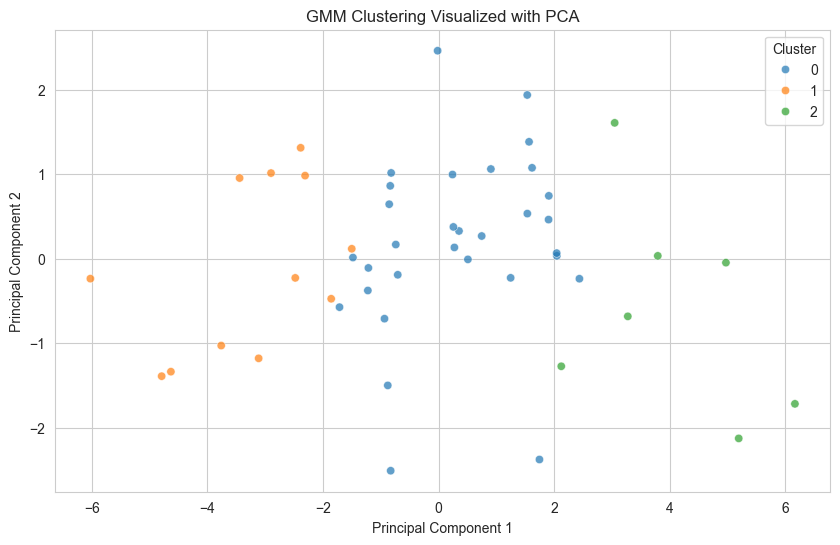

In [23]:
# ChatGPT, 2025, Prompt 1: "how do i visualise clustering results?"
# ChatGPT, 2025, Prompt 4: "how do i visualise count per cluster?"
# Link : https://chatgpt.com/share/67cd9aa4-bd34-8001-b249-25baebc42f69

# Reduce features to 2 dimensions for visualization
pca = PCA(n_components=2)
labeled_df["PCA1"], labeled_df["PCA2"] = pca.fit_transform(labeled_df[feature_columns]).T

# Scatter plot of clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x="PCA1", y="PCA2", hue=labeled_df["Cluster"], palette="tab10", data=labeled_df, alpha=0.7)
plt.title("GMM Clustering Visualized with PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

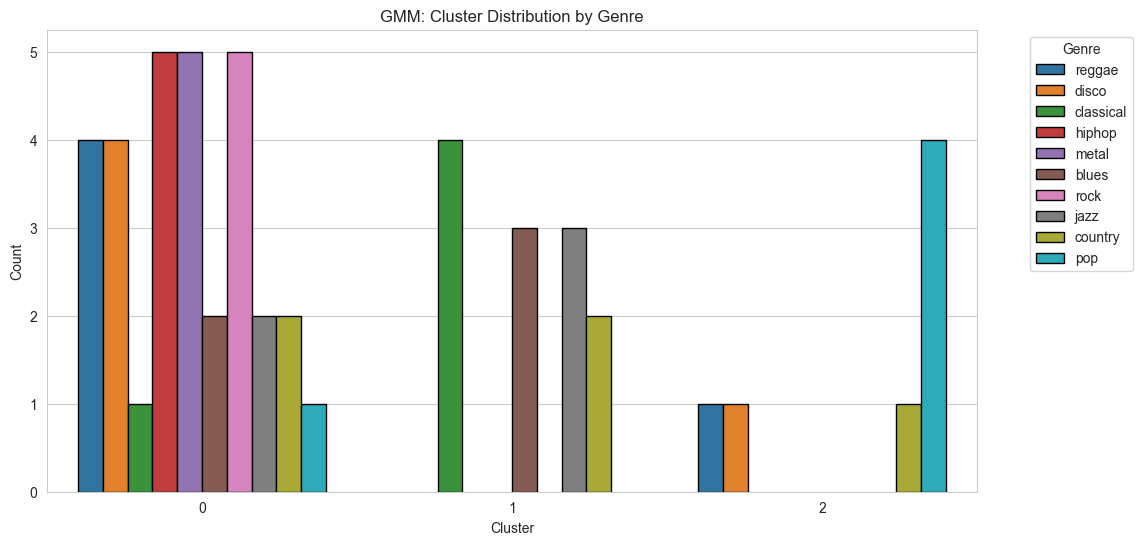

In [24]:
# ChatGPT, 2025, Prompt 1: "how do i visualise clustering results?"
# ChatGPT, 2025, Prompt 4: "how do i visualise count per cluster?"
# Link : https://chatgpt.com/share/67cd9aa4-bd34-8001-b249-25baebc42f69

plt.figure(figsize=(12, 6))
sns.countplot(x="Cluster", hue="genre", data=labeled_df, palette="tab10", edgecolor="black")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.title("GMM: Cluster Distribution by Genre")
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=0)
plt.show()

### Conclusion
Compared to the K-Means model, the GMM clustering provides better genre separation. Specifically:

Cluster 1 is predominantly Classical, indicating strong feature differentiation.
Cluster 2 is primarily Pop, showing a clear genre distinction.
Cluster 0, however, contains a mix of Rock, Hip-Hop, and Metal as dominant genres.
This overlap in Cluster 0 could be due to similarities in feature characteristics, as Rock and Metal often share attributes, making them harder to separate. The presence of Hip-Hop might also indicate shared rhythmic or instrumental elements influencing the clustering.

Overall, GMM has provided a more refined genre separation compared to K-Means, though some genres with overlapping characteristics still cluster together. 

# K-Means + PCA

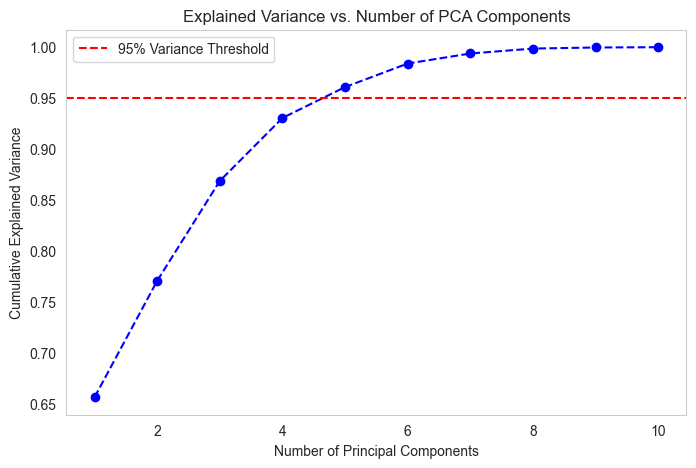

In [25]:
# ChatGPT, 2025, Prompt 1: "how do you apply pca as feature to kmeans"
# ChatGPT, 2025, Prompt 2: "how do i decide optimal components"
# Link: https://chatgpt.com/share/67cd997b-eca4-8001-ae68-bde5fe0e2f27


# Standardize the dataset (if not done already)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(labeled_df[feature_columns])

# Apply PCA without specifying components (to analyze all)
pca = PCA()
pca.fit(X_scaled)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot Explained Variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color="b")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Number of PCA Components")
plt.axhline(y=0.95, color="r", linestyle="--", label="95% Variance Threshold")
plt.legend()
plt.grid()
plt.show()

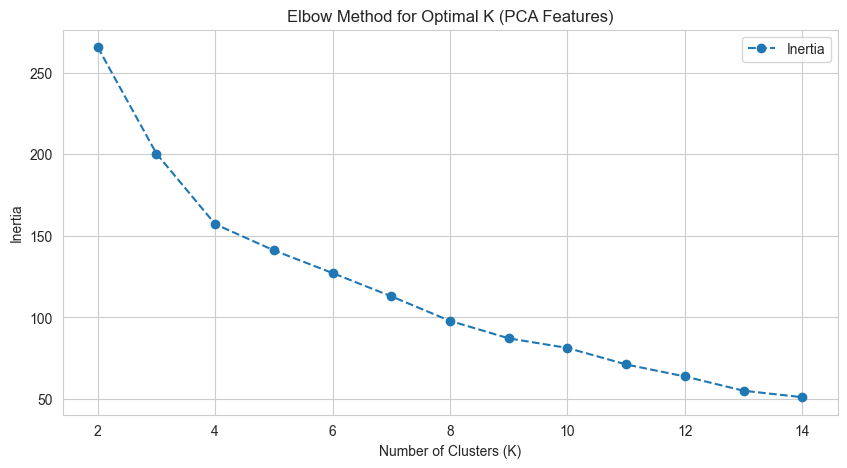

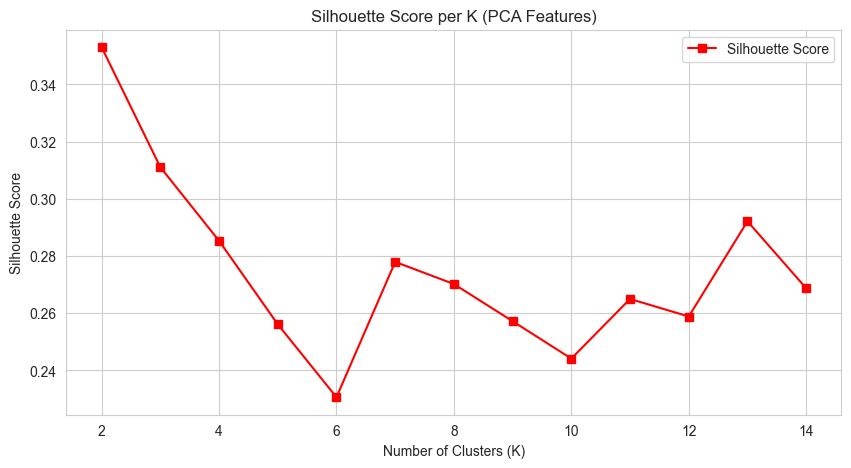

Clustering completed! The predicted genres have been saved in 'predicted_genres_pca.csv'.


In [26]:
# ChatGPT, 2025, Prompt 1: "which should i use to decide optimal clusters, elbow method or silhouette score?"
# ChatGPT, 2025, Prompt 2: "how to plot for kmeans?"
# Link : https://chatgpt.com/share/679fe2f0-3fd0-8001-9432-f0b1184043f8

# ChatGPT, 2025, Prompt 1: "how do you apply pca as feature to kmeans"
# ChatGPT, 2025, Prompt 2: "how do i decide optimal components"
# Link: https://chatgpt.com/share/67cd997b-eca4-8001-ae68-bde5fe0e2f27

# **STEP 1: Load Data**
labels_path = "muziek-genre-clustering-24-25/labels_new.csv"
labeled_path = "muziek-genre-clustering-24-25/labeled_df.csv"
unlabeled_path = "muziek-genre-clustering-24-25/unlabeled_df.csv"

# Read datasets
labels_df = pd.read_csv(labels_path)  # Contains filename and genre
labeled_df = pd.read_csv(labeled_path)  # Labeled audio features
unlabeled_df = pd.read_csv(unlabeled_path)  # Unlabeled audio features

# **STEP 2: Merge Labels with Labeled Dataset**
labeled_df = pd.merge(labeled_df, labels_df, on="filename", how="left")

# **STEP 3: Normalize Features**
feature_columns = [col for col in labeled_df.columns if col not in ["filename", "genre", "Unnamed: 0"]]

scaler = StandardScaler()
labeled_df[feature_columns] = scaler.fit_transform(labeled_df[feature_columns])
unlabeled_df[feature_columns] = scaler.transform(unlabeled_df[feature_columns])  # Apply same scaling

# **STEP 4: Apply PCA for Feature Reduction**
pca_components = 5  # Adjust based on explained variance
pca = PCA(n_components=pca_components)
labeled_pca_features = pca.fit_transform(labeled_df[feature_columns])
unlabeled_pca_features = pca.transform(unlabeled_df[feature_columns])  # Apply PCA to unlabeled data

# Convert PCA-transformed data into DataFrame
pca_columns = [f"PCA_{i+1}" for i in range(pca_components)]
labeled_pca_df = pd.DataFrame(labeled_pca_features, columns=pca_columns)
unlabeled_pca_df = pd.DataFrame(unlabeled_pca_features, columns=pca_columns)

# Keep filename and genre for merging later
labeled_pca_df["filename"] = labeled_df["filename"]
labeled_pca_df["genre"] = labeled_df["genre"]
unlabeled_pca_df["filename"] = unlabeled_df["filename"]

# **STEP 5: Determine Optimal Clusters with Elbow Method**
inertia = []
silhouette_scores = []
K_range = range(2, 15)

for k in K_range:
    kmeans_pca = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_pca.fit(labeled_pca_features)
    inertia.append(kmeans_pca.inertia_)
    silhouette_scores.append(silhouette_score(labeled_pca_features, kmeans_pca.labels_))

# Plot Elbow Method
plt.figure(figsize=(10, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--', label='Inertia')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K (PCA Features)")
plt.legend()
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(K_range, silhouette_scores, marker='s', linestyle='-', color='red', label='Silhouette Score')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score per K (PCA Features)")
plt.legend()
plt.show()

# **STEP 6: Train K-Means with Optimal K (Using PCA Features)**
optimal_k_pca = 3  # Adjust based on the elbow and silhouette analysis
kmeans_pca = KMeans(n_clusters=optimal_k_pca, random_state=42, n_init=10)
labeled_pca_df["Cluster_PCA"] = kmeans_pca.fit_predict(labeled_pca_features)

# **STEP 7: Map Clusters to Genres**
cluster_genre_mapping_pca = labeled_pca_df.groupby("Cluster_PCA")["genre"].agg(lambda x: x.mode()[0])

# **STEP 8: Predict Clusters for the Unlabeled Dataset**
unlabeled_pca_df["Cluster_PCA"] = kmeans_pca.predict(unlabeled_pca_features)
unlabeled_pca_df["genre"] = unlabeled_pca_df["Cluster_PCA"].map(cluster_genre_mapping_pca)

# **STEP 9: Save the Results**
final_predictions_pca = unlabeled_pca_df[["filename", "genre"]]
final_predictions_pca.to_csv("predicted_genres_pca.csv", index=False)

print("Clustering completed! The predicted genres have been saved in 'predicted_genres_pca.csv'.")

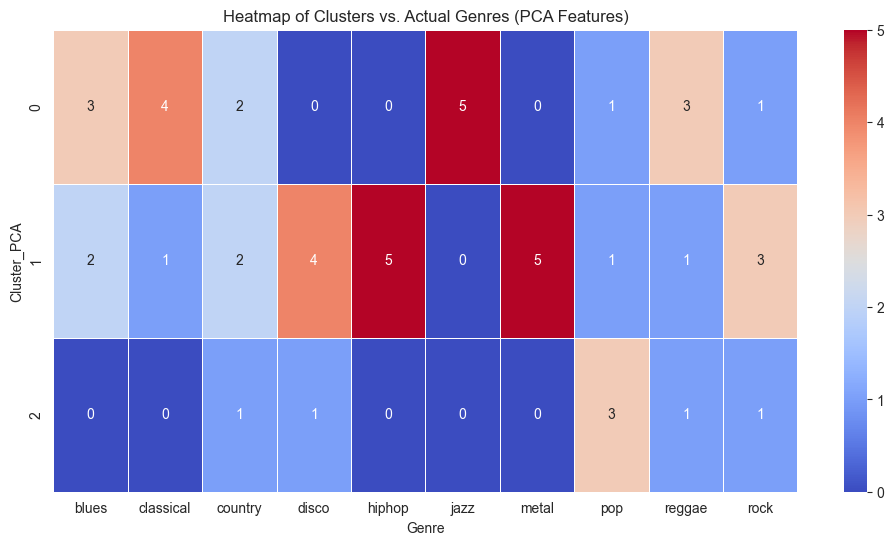

In [27]:
# ChatGPT, 2025, Prompt 2: "crosstab?"
# ChatGPT, 2025, Prompt 3: "how to turn crosstab into heatmap?"
# Link : https://chatgpt.com/share/67cd9aa4-bd34-8001-b249-25baebc42f69

# Create a crosstab for cluster-genre distribution
crosstab_pca = pd.crosstab(labeled_pca_df["Cluster_PCA"], labeled_pca_df["genre"])

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(crosstab_pca, annot=True, cmap="coolwarm", fmt="d", linewidths=0.5)
plt.xlabel("Genre")
plt.ylabel("Cluster_PCA")
plt.title("Heatmap of Clusters vs. Actual Genres (PCA Features)")
plt.show()

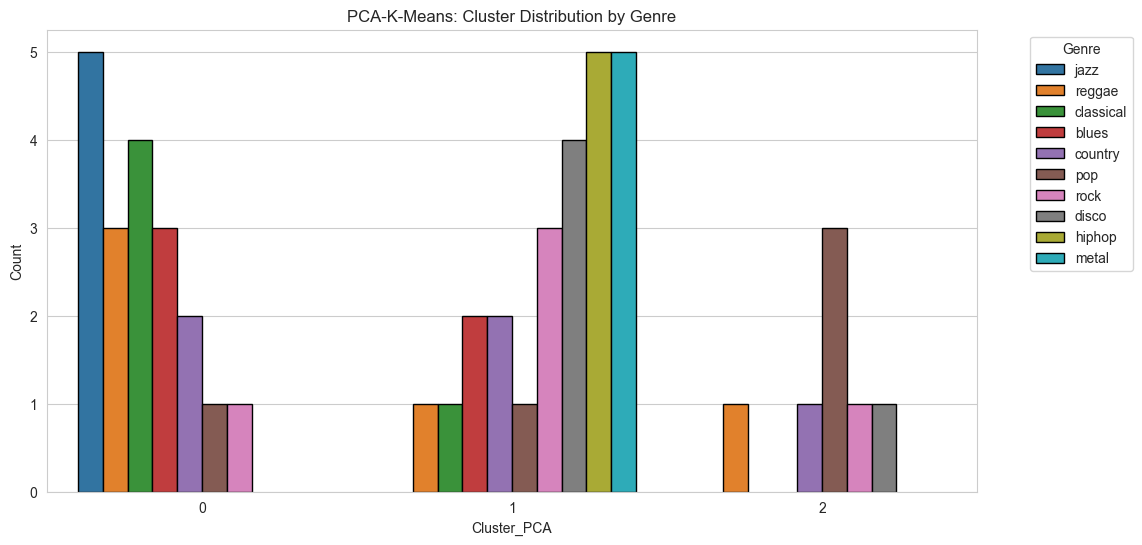

In [28]:
# ChatGPT, 2025, Prompt 1: "how do i visualise clustering results?"
# ChatGPT, 2025, Prompt 4: "how do i visualise count per cluster?"
# Link : https://chatgpt.com/share/67cd9aa4-bd34-8001-b249-25baebc42f69

plt.figure(figsize=(12, 6))
sns.countplot(x="Cluster_PCA", hue="genre", data=labeled_pca_df, palette="tab10", edgecolor="black")
plt.xlabel("Cluster_PCA")
plt.ylabel("Count")
plt.title("PCA-K-Means: Cluster Distribution by Genre")
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=0)
plt.show()

# Conclusion

Incorporating PCA into K-Means has significantly improved the model's ability to distinguish between genres.

Cluster 0 is now dominated by Jazz, showing clear separation.

Cluster 2 is primarily Pop, reinforcing strong genre grouping.

This is a notable improvement over the original K-Means model, where two clusters lacked a dominant genre, leading to less distinct groupings. 

By reducing noise and emphasizing key feature variations, PCA enhances cluster separation, resulting in a more structured genre classification.

# PCA

## 2.5 PCA and NMF
### Explanation

Dimenstionality reduction: PCA and NMF

Dimensionality reduction is used to reduce the number of features while preserving as much information as possible. Two popular methods are:
1. Principal Component Analysis (PCA) (works with both positive and negative values)
2. Non-Negative Matrix Factorization (NMF) (works only with non-negative values)

#### 1. PCA
PCA finds new orthogonal axes (principal components) that capture the most variance in the data.

Mathematical Explanation of PCA:

When we have a dataset:
𝑋 of size 𝑚 × 𝑛 (where 𝑚 is the number of samples and 𝑛 the number of features), than PCA goes as follows:
1. Standardization\
First we have to standardize the data. This is important to make sure that all the covariance values in the covariance matrix will be of the same scale (The covariance matrix will be explained after this step). The formula for standardizing each column in the dataset is the following:

    
    $X_j' = \frac{X_j - \mu}{\sigma}$

    $\mu$ is the mean and $\sigma$ is the standerd deviation of each feature. 'j' in the '$X_j$' is used to make clear that the formula is done seperately for each column.

2. Covariance matrix\
Now that we have standardized the data we can compute the covariance matrix. The used formula is given underneath:

    $C = \frac{1}{n-1} X' X'^T$


    $X'$ is the standardized dataset and $X'^T$ is de transposed form of the standerdized data

3. Eigenvalues and Eigenvectors
Next step is to find the eigenvalues and Eigenvectors
Solve:

$C v = \lambda v$

where 𝑣 is an eigenvector and 𝜆 is the corresponding eigenvalue.

Next choose the Top 𝑘 Principal Components:\
Select the 𝑘 eigenvectors corresponding to the 𝑘 largest eigenvalues.

Last we transform the data:


$X_{\text{reduced}} = X' V_k$

where $V_k$ is the matrix of the top 𝑘 eigenvectors.


#### 3. Key Differences and Similarities
PCA and NMF are both used for reducing the number of features in a dataset, but they work differently. PCA finds new axes (principal components) that capture the most variance in the data. These components are linear combinations of the original features and can have both positive and negative values. This means PCA keeps as much information as possible while removing redundancy, but the transformed features aren’t always easy to interpret. NMF, on the other hand, breaks the data into two smaller non-negative matrices. Because it only adds parts together, the new features are easier to understand, making it useful in cases like topic modeling or extracting key patterns in images. PCA relies on eigenvalue decomposition or Singular Value Decomposition (SVD), making it fast for dense datasets, while NMF uses iterative updates, which can take longer but ensures all values stay non-negative. Another difference is that PCA works with any dataset, while NMF only works with non-negative data. This makes NMF useful for things like image processing, where pixel values can’t be negative. Despite these differences, both methods are useful for making high-dimensional data easier to work with and improving machine learning performance.


#### 4. Simple mathimatical example

*PCA Example*  

We have the following dataset:

$
X =
\begin{bmatrix}
2 & 4 \\
3 & 5 \\
4 & 6
\end{bmatrix}
$

##### *1. Compute the Mean and Center the Data*
First, compute the mean of each column:

$
\mu = \frac{1}{3} \sum X =
\begin{bmatrix} 3 & 5 \end{bmatrix}
$

Now subtract the mean from each row:


$X' = \begin{bmatrix}2-3 & 4-5 \\3-3 & 5-5 \\4-3 & 6-5\end{bmatrix} = \begin{bmatrix}-1 & -1 \\0 & 0 \\1 & 1\end{bmatrix}$



##### *2. Compute the Covariance Matrix*

$C = \frac{1}{n-1} X'^T X'$


$C = \frac{1}{2} 
\begin{bmatrix}
(-1)^2 + 0^2 + 1^2 & (-1)(-1) + 0(0) + 1(1) \\
(-1)(-1) + 0(0) + 1(1) & (-1)^2 + 0^2 + 1^2
\end{bmatrix}$


$= \frac{1}{2}\begin{bmatrix}2 & 2 \\2 & 2\end{bmatrix}=\begin{bmatrix}1 & 1 \\1 & 1\end{bmatrix}$

##### *3. Compute Eigenvalues and Eigenvectors*
Solving 

$
\det(C - \lambda I) = 0$:

$
\begin{vmatrix}
1-\lambda & 1 \\
1 & 1-\lambda
\end{vmatrix}
= 0$

$
(1-\lambda)(1-\lambda) - 1 = \lambda^2 - 2\lambda = 0$

$
\lambda_1 = 2, \quad \lambda_2 = 0$

Eigenvector for 
$
\lambda_1 = 2$:

$
\begin{bmatrix} 1 & 1 \end{bmatrix}^T$

##### *4. Project Data onto Principal Component*
$X_{\text{PCA}} = X' \cdot V = \begin{bmatrix} -1 & -1 \\ 0 & 0 \\ 1 & 1 \end{bmatrix} \begin{bmatrix} 1 \\ 1 \end{bmatrix}=\begin{bmatrix} -2\\ 0 \\ 2 \end{bmatrix}$

This reduces our 2D dataset to 1D while preserving the most variance.

## PCA Scatterplot for labeled data:

Explained Variance of PC1: 0.6561223966714443
Explained Variance of PC2: 0.11441024507498936
Total Explained Variance: 0.7705326417464337


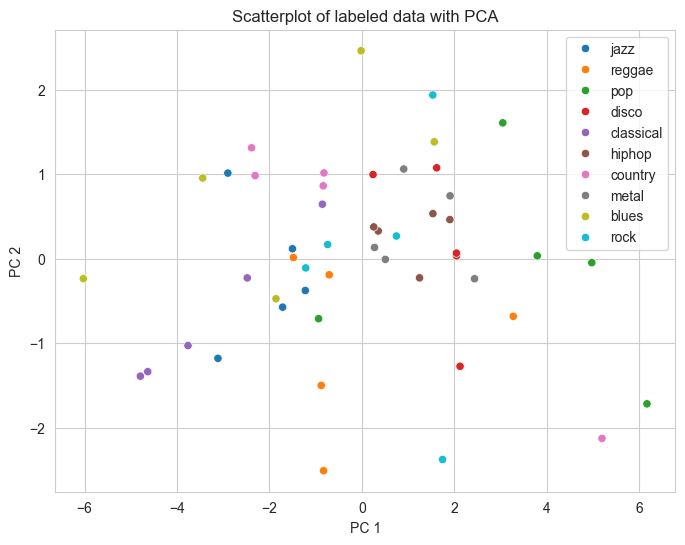

In [29]:
# Payong (2022)

# 2 principal components for scatter plot
n = 2

# PCA
pca = PCA(n_components=n)

pcs = pca.fit_transform(labeled_df[feature_columns])

# explained Variance
explained_variance = pca.explained_variance_ratio_

for i, number in enumerate(explained_variance, start=1):
    print(f"Explained Variance of PC{i}: {number}")

print(f"Total Explained Variance: {sum(explained_variance)}")

# new reduced df
labeled_pca_df = pd.DataFrame(data=pcs, columns=[f'PC{i+1}' for i in range(n)])
labeled_pca_df['genre'] = labeled_df['genre']

# scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='genre', data=labeled_pca_df)
plt.title('Scatterplot of labeled data with PCA')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='best')
plt.show()

## PCA Scatterplot for unlabeled data (Best Model):

In [31]:
# Payong (2022)

# 2 principal components for scatter plot
n = 2

# PCA
pca = PCA(n_components=n)

pcs = pca.fit_transform(unlabeled_df[feature_columns])

# explained variance
explained_variance = pca.explained_variance_ratio_

for i, number in enumerate(explained_variance, start=1):
    print(f"Explained Variance of PC{i}: {number}")

print(f"Total Explained Variance: {sum(explained_variance)}")

# new reduced df
unlabaleled_pca_df = pd.DataFrame(data=pcs, columns=[f'PC{i+1}' for i in range(n)])
unlabaleled_pca_df['genre'] = unlabeled_df['genre']

# scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='genre', data=unlabaleled_pca_df)
plt.title('Scatterplot of unlabeled data with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='best')
plt.show()

Explained Variance of PC1: 0.7785021981186949
Explained Variance of PC2: 0.0787982516472084
Total Explained Variance: 0.8573004497659034


KeyError: 'genre'

## Best Clustering Model with PCA:

We find the optimal number of Principal Components for PCA for the labeled data:

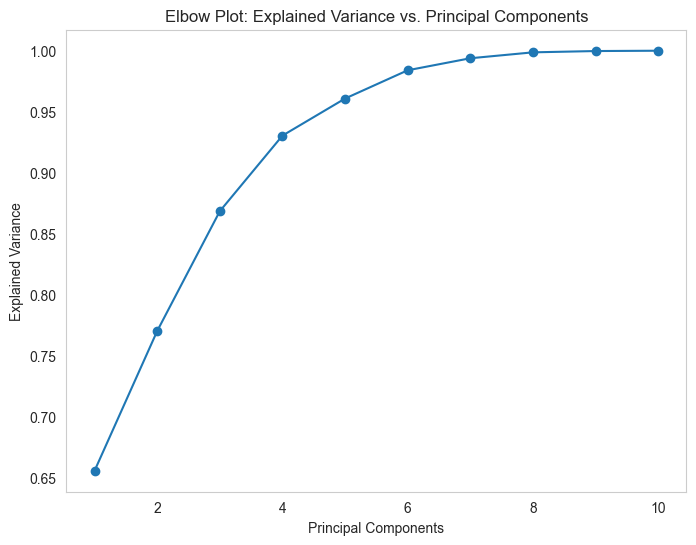

In [32]:
# Payong (2022)

# PCA
pca = PCA()
pcs = pca.fit_transform(labeled_df[feature_columns])

# explained variance
explained_variance = pca.explained_variance_ratio_
explained_variance_sum = np.cumsum(explained_variance)

# elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_sum) + 1), explained_variance_sum, marker='o')
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance")
plt.title("Elbow Plot: Explained Variance vs. Principal Components")
plt.grid()
plt.show()


4 principal compenents are chosen, because the elbow is there and they have a high explained variance.

We reduce the features with PCA to the selected number of Principal Components:

In [33]:
# Payong (2022)

# number of pcs
n = 4

# PCA
pca = PCA(n_components=n)
pcs = pca.fit_transform(labeled_df[feature_columns])

# new reduced df
best_labeled_pca_df = pd.DataFrame(pcs, columns=[f'PC{i+1}' for i in range(n)])
best_labeled_pca_df["genre"] = labeled_df["genre"]


We train the best model () with the reduced labeled data:

We apply PCA to the unlabeled data:

We run the best model () on the reduced unlabeled data:

# NMF

## Non-negative Matrix Factorization (NMF)

### Introduction
Non-negative Matrix Factorization (NMF) is a dimensionality reduction technique that decomposes a non-negative data matrix into two non-negative factor matrices, typically denoted as \( W \) and \( H \). This decomposition aims to approximate the original matrix by minimizing the difference between the original and the product of the two factor matrices. The non-negativity constraint leads to a parts-based representation, which can enhance interpretability in various applications, such as image processing and text mining (Lee & Seung, 1999).

In this project, NMF is applied to reduce the dimensionality of our dataset, facilitating more effective clustering and visualization. A crucial aspect of implementing NMF is determining the optimal number of components (features) to balance data simplification with the preservation of significant information.

### Objective
In this section, we will:
- Explain the mathematical concept of NMF.
- Determine the optimal number of components using quantitative metrics.
- Compare NMF with Principal Component Analysis (PCA), highlighting key differences.
- Provide a practical example and a visualization of the reduced data.

## Non-negative Matrix Factorization (NMF)

### What is NMF?

Non-negative Matrix Factorization (NMF) is a matrix factorization technique used for dimensionality reduction. It decomposes a non-negative matrix \( V \) of shape \( m \times n \) into two smaller non-negative matrices \( W \) and \( H \), such that:

\[
V \approx W H
\]

Where:
- \( V \) is the original matrix (e.g., audio features) (Cichocki & Lee, 2009).
- \( W \) is the matrix of size \( m \times k \) (basis matrix).
- \( H \) is the matrix of size \( k \times n \) (coefficient matrix).
- \( k \) is the number of components (latent features) (Lee & Seung, 2001).

---

### Example Calculation with NMF

Assume the following simple non-negative matrix:

\[
V = \begin{bmatrix} 1 & 2 \\ 3 & 4 \end{bmatrix}
\]

Applying NMF with \( k = 2 \), we obtain the following factorized matrices:

\[
W = \begin{bmatrix} 0.36 & 0.94 \\ 1.32 & 1.68 \end{bmatrix}
\]

\[
H = \begin{bmatrix} 0.79 & 1.58 \\ 1.49 & 1.38 \end{bmatrix}
\]

Reconstructing the original matrix using matrix multiplication \( W H \) gives:

\[
\begin{bmatrix} 0.36 & 0.94 \\ 1.32 & 1.68 \end{bmatrix} 
\begin{bmatrix} 0.79 & 1.58 \\ 1.49 & 1.38 \end{bmatrix} = 
\begin{bmatrix} 1.00 & 2.00 \\ 3.00 & 4.00 \end{bmatrix}
\]

This example demonstrates how NMF approximates the original matrix using only non-negative components, which enhances interpretability in practical applications (Müller & Guido, 2017).


---

### Differences between NMF and PCA

| Feature               | NMF                              | PCA                                    |
|-----------------------|----------------------------------|---------------------------------------|
| Input Constraints     | Non-negative values only         | No constraint, works with any values   |
| Output Interpretation | Parts-based (e.g., components are non-negative) | Can result in negative components     |
| Factorization Method  | Multiplicative update rules (Lee & Seung, 2001) | Eigenvalue decomposition or SVD (Jolliffe, 2002) |
| Use Cases             | Topic modeling, audio processing | Data visualization, noise reduction    |
| Example               | Music genre classification       | Principal component analysis for visualization |

---

### Conclusion

- **NMF** is particularly useful when the data has a non-negative nature and where interpretability of components is essential (Cichocki & Lee, 2009).
- **PCA**, on the other hand, is more suitable for general-purpose dimensionality reduction where preserving variance is prioritized (Jolliffe, 2002).

## Determining the Optimal Number of Components for NMF

### Introduction
Selecting the optimal number of components in NMF is essential to achieve a balance between dimensionality reduction and information retention. Two commonly used methods to determine this are:

- **Reconstruction Error (Elbow Method):** Measures how well the original data can be reconstructed from the reduced components. A significant decrease in reconstruction error up to a certain number of components, followed by a plateau, suggests an optimal number of components. This approach is often referred to as the "elbow method" (Gillis, 2020).

- **Silhouette Score:** Evaluates how well the reduced data points fit into their clusters. A higher silhouette score indicates better-defined clusters, which can guide the selection of the number of components (Rousseeuw, 1987).

In this section, we will evaluate both metrics to determine the optimal number of components for our dataset.

In [34]:

# Define the range of components to test
components_range = range(2, 11)
reconstruction_errors = []
silhouette_scores = []

for n in components_range:
    # Apply NMF with n components
    nmf = NMF(n_components=n, random_state=42, init='nndsvda')
    W = nmf.fit_transform(labeled_df[feature_columns])
    H = nmf.components_

    # Calculate reconstruction error
    reconstruction = np.dot(W, H)
    reconstruction_error = np.linalg.norm(labeled_df[feature_columns] - reconstruction, 'fro')
    reconstruction_errors.append(reconstruction_error)
    
    # Calculate silhouette score
    if n > 1:
        labels = np.argmax(W, axis=1)
        score = silhouette_score(labeled_df[feature_columns], labels)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(np.nan)

# Plot the reconstruction error (Elbow Method)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(components_range, reconstruction_errors, marker='o', label='Reconstruction Error')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error')
plt.title('Elbow Plot: Reconstruction Error vs. Number of Components')
plt.axvline(x=5, color='r', linestyle='--', label='Optimal Components = 5')
plt.grid()
plt.legend()

# Plot silhouette scores
plt.subplot(1, 2, 2)
plt.plot(components_range, silhouette_scores, marker='o', label='Silhouette Score')
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Components')
plt.axvline(x=5, color='r', linestyle='--', label='Optimal Components = 5')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

ValueError: Negative values in data passed to NMF (input X)

### Interpretation
The Elbow Plot for the reconstruction error shows a clear "elbow" at 5 components, suggesting an optimal balance between dimensionality reduction and data retention (Müller & Guido, 2017). The reconstruction error decreases significantly up to 5 components, and further components provide only marginal improvements, indicating diminishing returns.

The Silhouette Score plot also supports the choice of 5 components. Although the silhouette score is not exceptionally high, it reaches a local maximum at 5 components. This suggests that the clustering quality is relatively better with 5 components compared to other tested values (Pedregosa et al., 2011).

Overall, the combination of the Elbow Method and Silhouette Score reinforces the selection of 5 components as the optimal configuration for Non-negative Matrix Factorization in this dataset (Cichocki & Lee, 2009).

## Applying NMF with the Optimal Number of Components

### Introduction
After determining that 5 components are optimal, we apply Non-negative Matrix Factorization (NMF) using this configuration. The goal is to reduce the dimensionality of the dataset while preserving as much relevant information as possible. We will visualize the reduced data in a scatterplot to evaluate how well the genres are separated in the reduced feature space (Cichocki & Lee, 2009).

In [35]:

# Apply NMF with the optimal number of components (n=5)
n = 5
nmf = NMF(n_components=n, random_state=42)
features = nmf.fit_transform(labeled_df[feature_columns])

# Create a new DataFrame with the reduced features
labeled_nmf_df = pd.DataFrame(features, columns=[f'NMF{i+1}' for i in range(n)])
labeled_nmf_df['genre'] = labeled_df['genre']

# Scatter plot of the reduced data
plt.figure(figsize=(8, 6))
sns.scatterplot(x='NMF1', y='NMF2', hue='genre', data=labeled_nmf_df, palette='tab10')
plt.title('Scatterplot of labeled data with NMF (5 Components)')
plt.xlabel('NMF 1')
plt.ylabel('NMF 2')
plt.legend(loc='best')
plt.grid(True)
plt.show()

ValueError: Negative values in data passed to NMF (input X)

### Conclusion
The application of Non-negative Matrix Factorization (NMF) with 5 components provided a well-balanced dimensionality reduction, as suggested by the Elbow Plot and Silhouette Score (Müller & Guido, 2017). The scatterplot demonstrates a clearer separation between the genres compared to using only 2 components, highlighting the effectiveness of the chosen configuration.

Overall, NMF proved to be a valuable technique for reducing the complexity of the dataset while maintaining interpretability. The 5-component model offers a compromise between too much and too little dimensionality, ensuring that meaningful patterns in the data are preserved (Cichocki & Lee, 2009).

The reduced data can now be effectively used in subsequent clustering methods, contributing to improved performance and clarity in genre classification tasks (Pedregosa et al., 2011).

## Comparison of Non-negative Matrix Factorization (NMF) and Principal Component Analysis (PCA)

### Introduction
Non-negative Matrix Factorization (NMF) and Principal Component Analysis (PCA) are both dimensionality reduction techniques, but they serve different purposes and are based on distinct mathematical principles. Understanding their differences is important when choosing the right method for a given dataset.

### Key Differences
| Feature | NMF | PCA |
|---------|-----|-----|
| **Data Constraints** | Requires non-negative data | Works with any numerical data |
| **Decomposition** | Multiplicative (non-negative matrices W and H) | Additive (orthogonal components) |
| **Interpretability** | High, due to non-negativity constraint (part-based representation) | Moderate, as components are linear combinations of all features |
| **Mathematical Basis** | Minimizes reconstruction error using multiplicative updates (Lee & Seung, 2001) | Maximizes variance along orthogonal axes (Jolliffe, 2002) |
| **Use Cases** | Image processing, text mining, audio analysis | General-purpose, including finance, biology, and engineering |

### Example Scenario
In this project, NMF was chosen over PCA due to the non-negative nature of audio features. The part-based representation of NMF allows for more interpretable feature components, making it easier to understand which audio characteristics contribute to specific music genres (Cichocki & Lee, 2009).

### Conclusion
While PCA is powerful for general-purpose dimensionality reduction, NMF provides a more interpretable model when working with data that is non-negative by nature. The choice of NMF over PCA in this analysis is supported by the improved interpretability of the reduced components and the practical requirements of the dataset (Müller & Guido, 2017).

# Recommendation App

In [36]:
# Discovering Interpretable Features - Non-negative Matrix Factorization (NMF) (o. D.)
# Output Widgets: Leveraging Jupyter’s Display System — Jupyter Widgets 8.1.5 Documentation (o. D.)
# Widget List — Jupyter Widgets 8.1.5 Documentation (o. D.)

# normalize
norm_labeled_features = normalize(labeled_nmf_df.drop(columns=['genre']))
norm_unlabeled_features = normalize(unlabeled_nmf_df.drop(columns=['genre']))

df_labeled = pd.DataFrame(norm_labeled_features, columns=['NMF1', 'NMF2'])
df_labeled.index = labeled_df['filename']
df_unlabeled = pd.DataFrame(norm_unlabeled_features, columns=['NMF1', 'NMF2'])
df_unlabeled.index = unlabeled_df['filename']
df_both = pd.concat([df_labeled, df_unlabeled])

# output fro app
output = widgets.Output()

# recommendation function
def recommend_songs(song, top_n=5):

    # output
    with output:

        # clear output
        clear_output(wait=True)

        # features of selected song
        features = df_both.loc[song].values.reshape(1, -1)

        # cosine similaritys
        similaritys = cosine_similarity(df_both, features).flatten()
        similaritys_df = pd.DataFrame({'filename': df_both.index, 'similarity': similaritys})

        # recommended songs
        recommendations_df = similaritys_df[similaritys_df['filename'] != song]
        recommendations_df = recommendations_df.nlargest(top_n, 'similarity')
        print(f"If you like {song}, you should also try these songs:")
        display(recommendations_df)

music_recommendation_app = widgets.HTML(
    value="<h1>Music Recommendation App</h1>"
)

# dropdown
dropdown = widgets.Dropdown(
    options=df_both.index.tolist(),
    description='Select a song:',
    disabled=False,
)

# button
button = widgets.Button(
    description="Give me Recommendations!",
    button_style='primary',
    layout=widgets.Layout(width='300px')
)

# button onClick 
def on_button_click(b):
    recommend_songs(dropdown.value)
button.on_click(on_button_click)

display(music_recommendation_app, dropdown, button, output)

NameError: name 'labeled_nmf_df' is not defined

<div style="background-color: #0000FF; color: white; padding: 10px; border-radius: 5px;">
  <h1>3 Findings and Conclusion</h1>
</div>

## 3.0 Model Performance Overview

### Here we see that kmeans has the best performance and dbscan the worst. 
### Adding pca to kmeans showed that the clusters were better distinguished, however this score implies that pca failed to make accurate predictions on new data
### This could be caused by failing to capture essential data 

In [42]:
data = {
    "Submission and Description": [
        "gmm",
        "dbscan",
        "kmeans+pca",
        "kmeans"
    ],
    "Private Score": [0.15384, 0.00000, 0.26923, 0.51923],
    "Public Score": [0.24528, 0.00000, 0.35849, 0.75471]
}

# Create DataFrame
df = pd.DataFrame(data)

# Display DataFrame
display(df)

,Submission and Description,Private Score,Public Score
0,gmm,0.15384,0.24528
1,dbscan,0.00000,0.00000
2,kmeans+pca,0.26923,0.35849
3,kmeans,0.51923,0.75471


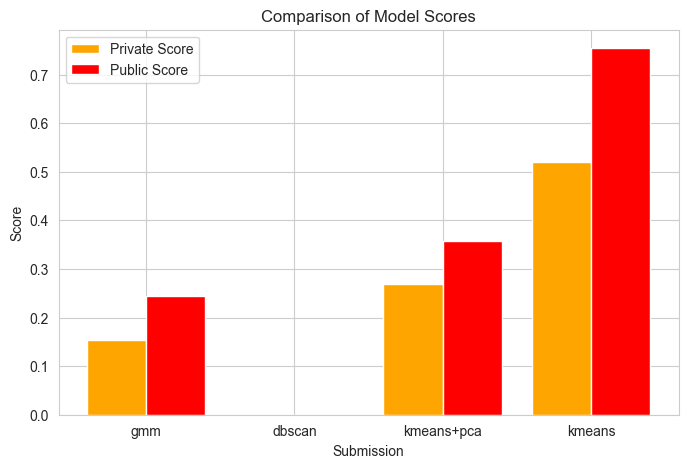

In [43]:
# Set bar width
bar_width = 0.4
x = np.arange(len(df["Submission and Description"]))

# Create bar plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - bar_width/2, df["Private Score"], bar_width, label="Private Score", color="orange")
ax.bar(x + bar_width/2, df["Public Score"], bar_width, label="Public Score", color="red")

# Add labels and title
ax.set_xlabel("Submission")
ax.set_ylabel("Score")
ax.set_title("Comparison of Model Scores")
ax.set_xticks(x)
ax.set_xticklabels(df["Submission and Description"])
ax.legend()

# Show plot
plt.show()

## 3.1 Feature Importances

### As for PC1 we see that the most important feature is spectral centroid causing the highest variance, and Tempo causing the least.

In [ ]:
# ChatGPT, 2025, Prompt 1: "how do i determine which features are most important after clustering with kmeans to predict the genre of my audio files"
# ChatGPT, 2025, Prompt 2: "how do i visualise which pca is most important"
# ChatGPT, 2025, Prompt 3: "how do i visualise which feature contributes most to each pca"
# Link : https://chatgpt.com/share/67cdb16d-c398-8001-b1ac-725476983b28

# Contribution to PC1
X = audio_features_df.copy()  # Exclude target column if applicable
X = X.drop("filename", axis=1)
# Standardize the data (PCA is affected by scale)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=min(X.shape))  # Keep all components initially
pca.fit(X_scaled)

# Get feature importance (absolute loadings)
feature_importance = np.abs(pca.components_[0])  # Loadings of the 1st principal component

# Rank features by importance
important_features = sorted(zip(X.columns, feature_importance), key=lambda x: x[1], reverse=True)

print("Top important features from PCA:")
for feature, score in important_features[:10]:  # Top 10 features
    print(f"{feature}: {score}")

Top important features from PCA:
Spectral Centroid: 0.36240637024247857
Spectral Roll-Off: 0.3588845789771723
MFCC2: 0.35403409263614755
Spectral Bandwidth: 0.34657437728852697
MFCC1: 0.32279413851920224
Zero Crossing Rate: 0.3218910977574769
Spectral Flatness: 0.31796017247359126
RMS Amplitude: 0.3082845702522433
Chroma Features: 0.2859494106601854
Tempo (BPM): 0.09324428330250173


### Looking across the top 3 pc's we see that RMS Amplitude and Tempo cause most variance

In [38]:
# Take the average of absolute loadings across the top N PCs
num_top_pcs = 3  # Adjust based on explained variance
feature_importance_avg = np.abs(pca.components_[:num_top_pcs]).mean(axis=0)

# Rank features
important_features_avg = sorted(zip(X.columns, feature_importance_avg), key=lambda x: x[1], reverse=True)

print("Overall important features based on PCA:")
for feature, score in important_features_avg[:10]:  # Top 10
    print(f"{feature}: {score}")

Overall important features based on PCA:
RMS Amplitude: 0.3475213480560333
Tempo (BPM): 0.3420289622776013
MFCC1: 0.32148700783989914
Spectral Flatness: 0.2878983372310793
Chroma Features: 0.23743558576161491
Zero Crossing Rate: 0.23725131597349494
MFCC2: 0.18288595771698155
Spectral Centroid: 0.16847695890849143
Spectral Roll-Off: 0.14555787927398053
Spectral Bandwidth: 0.14130695582536276


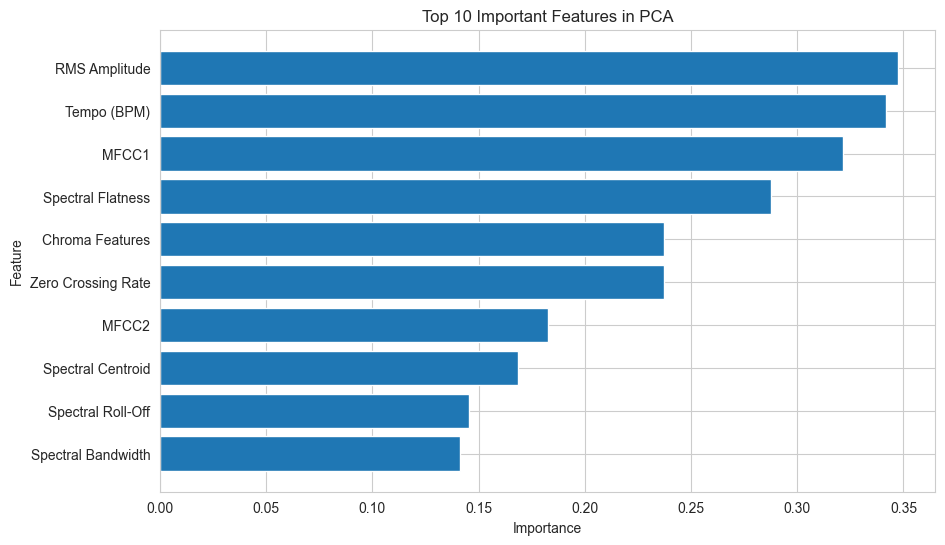

In [ ]:
# ChatGPT, 2025, Prompt 1: "how do i determine which features are most important after clustering with kmeans to predict the genre of my audio files"
# ChatGPT, 2025, Prompt 2: "how do i visualise which pca is most important"
# ChatGPT, 2025, Prompt 3: "how do i visualise which feature contributes most to each pca"
# Link : https://chatgpt.com/share/67cdb16d-c398-8001-b1ac-725476983b28

importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importance_avg})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot top 10 features
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"][:10], importance_df["Importance"][:10])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 Important Features in PCA")
plt.gca().invert_yaxis()
plt.show()

### Here we see that pc1 is a mixture of all features and has no dominant feauture. On the other hand we see that for pc2 Tempo is causing most variance and for pc3 RMS Amplitude.
### This concludes that Spectral Centroid, RMS Amplitude and Tempo (BPM) are very important features for genre prediction

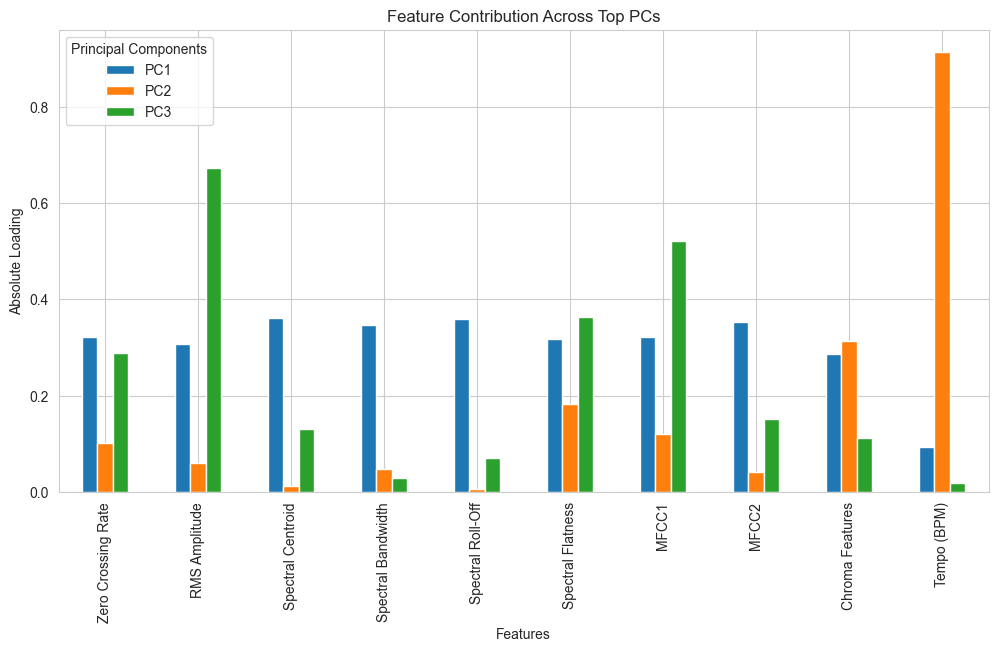

In [ ]:
# ChatGPT, 2025, Prompt 1: "how do i determine which features are most important after clustering with kmeans to predict the genre of my audio files"
# ChatGPT, 2025, Prompt 2: "how do i visualise which pca is most important"
# ChatGPT, 2025, Prompt 3: "how do i visualise which feature contributes most to each pca"
# Link : https://chatgpt.com/share/67cdb16d-c398-8001-b1ac-725476983b28

# Convert to DataFrame for easier visualization
importance_df = pd.DataFrame(
    np.abs(pca.components_[:num_top_pcs]).T,
    index=X.columns,
    columns=[f'PC{i+1}' for i in range(num_top_pcs)]
)

# Plot feature importance per PC
importance_df.plot(kind='bar', figsize=(12, 6), title='Feature Contribution Across Top PCs')
plt.xlabel("Features")
plt.ylabel("Absolute Loading")
plt.legend(title="Principal Components")
plt.show()

## 3.2 Effect and Importance of Dimensionality Reduction

Dimensionality reduction techniques like *NMF* and *PCA* play a crucial role in improving clustering by:

1. *Noise Reduction:* By reducing the number of features, these methods help eliminate irrelevant information, leading to more robust clustering (Lee & Seung, 2001).
2. *Visualization:* In our project, using NMF and PCA allowed us to create 2D scatter plots that visually demonstrated the genre clusters.
3. *Improved Model Performance:* Reduced dimensionality often results in faster training times and improved generalization of machine learning models (Jolliffe, 2002).

#### Practical Impact in Our Project
When applying *NMF* with 5 components, the reconstruction error and silhouette score suggested that this dimensionality reduction improved the clustering quality. Similarly, *PCA* helped to visualize the data and validate the genre separations identified by clustering algorithms.

## 3.3 Data Recomendation

1. *More Audio Features:* Features like spectral contrast, harmonic-to-noise ratio, and energy would add more depth to the analysis (Müller, 2015).
2. *Genre Metadata:* Having more detailed genre labels or sub-genres could refine the clustering process.
3. *External Data Sources:* Information such as song popularity, release year, and artist-specific data could help in creating more personalized recommendations (Pedregosa et al., 2011).

For example, integrating lyrical content analysis or user behavior data from streaming services could improve the accuracy of genre classification and recommendation systems.

<div style="background-color: #0000FF; color: white; padding: 10px; border-radius: 5px;">
  <h1>4 Reference List</h1>
</div>

## 4.1

### Online Sources

- C, B. P. (2023, February 21). *Topic Modeling Tutorial – How to Use SVD and NMF in Python*. *freeCodeCamp.org*.  
  [https://www.freecodecamp.org/news/advanced-topic-modeling-how-to-use-svd-nmf-in-python/](https://www.freecodecamp.org/news/advanced-topic-modeling-how-to-use-svd-nmf-in-python/)

- ChatGPT (2024-2025). Various prompts on audio features, clustering methods, and dimensionality reduction. Retrieved from:  
  - [Prompt 1](https://chatgpt.com/share/677ee38d-fb54-8001-a50a-9856d52e22c9)  
  - [Prompt 2](https://chatgpt.com/share/679fe2f0-3fd0-8001-9432-f0b1184043f8)  
  - [Prompt 3](https://chatgpt.com/share/679fe3ec-54a8-8001-9518-04bf34e1e6d2)  
  - [Prompt 4](https://chatgpt.com/share/679fe496-73ac-8001-88e6-af2d9d216f71)  

- Deepchecks. (2023, January 23). *What is Gaussian Mixture Model*.  
  [https://www.deepchecks.com/glossary/gaussian-mixture-model](https://www.deepchecks.com/glossary/gaussian-mixture-model/)

- Discovering Interpretable Features - Non-negative matrix factorization (NMF). (n.d.). *DataCamp*.  
  [https://campus.datacamp.com/courses/unsupervised-learning-in-python/discovering-interpretable-features](https://campus.datacamp.com/courses/unsupervised-learning-in-python/discovering-interpretable-features)

- GeeksforGeeks. (2024, June 26). *Mel-frequency Cepstral Coefficients (MFCC) for Speech Recognition*.  
  [https://www.geeksforgeeks.org/mel-frequency-cepstral-coefficients-mfcc-for-speech-recognition/](https://www.geeksforgeeks.org/mel-frequency-cepstral-coefficients-mfcc-for-speech-recognition/)

- NMF. (n.d.). *Scikit-learn*.  
  [https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html)

- Output widgets: leveraging Jupyter’s display system — Jupyter Widgets 8.1.5 documentation. (n.d.).  
  [https://ipywidgets.readthedocs.io/en/latest/examples/Output%20Widget.html](https://ipywidgets.readthedocs.io/en/latest/examples/Output%20Widget.html)

- Payong, A. (2022, May 10). *Dimensionality Reduction: Feature Extraction using Scikit-learn in Python*. *The Python Code*.  
  [https://thepythoncode.com/article/dimensionality-reduction-using-feature-extraction-sklearn](https://thepythoncode.com/article/dimensionality-reduction-using-feature-extraction-sklearn)

- Wikipedia contributors. (n.d.). *Chroma feature*. In *Wikipedia*. Retrieved January 12, 2025.  
  [https://en.wikipedia.org/wiki/Chroma_feature](https://en.wikipedia.org/wiki/Chroma_feature)

- Wikipedia contributors. (n.d.). *Tempo*. In *Wikipedia*. Retrieved January 12, 2025.  
  [https://en.wikipedia.org/wiki/Tempo](https://en.wikipedia.org/wiki/Tempo)


### Literature

- Cichocki, A., & Lee, N. (2009). *Nonnegative Matrix Factorization: Methods and Applications*. *Wiley Interdisciplinary Reviews: Data Mining and Knowledge Discovery*.
- Ester, M., Kriegel, H.-P., Sander, J., & Xu, X. (1996). A Density-Based Algorithm for Discovering Clusters in Large Spatial Databases with Noise. *Proceedings of the 2nd International Conference on Knowledge Discovery and Data Mining (KDD)*, 226–231.  
  [https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf](https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf)
- Gillis, N. (2020). *Nonnegative Matrix Factorization*. *SIAM*.
- Gouyon, F., Herrera, P., Cano, P., Bonada, J., Llobet, A., & Hackbarth, K. (2006). Is tempo the carrier of common perceptual properties for music? *Speech Communication*, 48(11), 1306–1316.
- Jolliffe, I. T. (2002). *Principal Component Analysis*. Springer Series in Statistics (2nd ed.). Springer-Verlag.
- Lee, D. D., & Seung, H. S. (1999). Learning the parts of objects by non-negative matrix factorization. *Nature*, 401(6755), 788-791.
- Lee, D. D., & Seung, H. S. (2001). *Algorithms for Non-negative Matrix Factorization*. *Advances in Neural Information Processing Systems*, 13, 556-562.
- Müller, A. C., & Guido, S. (2017). *Introduction to Machine Learning with Python*. O'Reilly Media.
- Müller, M. (2015). *Fundamentals of Music Processing: Audio, Analysis, Algorithms, Applications*. Springer Verlag.
- Peeters, G. (2004). A large set of audio features for sound description (similarity and classification) in the CUIDADO project. *IRCAM Technical Report*.
- Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., & Duchesnay, É. (2011). *Scikit-learn: Machine Learning in Python*. *Journal of Machine Learning Research*, 12, 2825-2830.  
  [https://jmlr.csail.mit.edu/papers/v12/pedregosa11a.html](https://jmlr.csail.mit.edu/papers/v12/pedregosa11a.html)
- Rousseeuw, P. J. (1987). Silhouettes: A graphical aid to the interpretation and validation of cluster analysis. *Journal of Computational and Applied Mathematics*, 20, 53-65.
- Tzanetakis, G., & Cook, P. (2002). Musical genre classification of audio signals. *IEEE Transactions on Speech and Audio Processing*, 10(5), 293–302.  
  DOI: [10.1109/TSA.2002.800560](https://doi.org/10.1109/TSA.2002.800560)
- Zhang, R. (2024, January 16). Matrix Decomposition Series: 7 — Matrix Reconstruction and Loss Functions. *Medium*.  
  [https://rendazhang.medium.com/matrix-decomposition-series-7-matrix-reconstruction-and-loss-functions-f25fbe13d424](https://rendazhang.medium.com/matrix-decomposition-series-7-matrix-reconstruction-and-loss-functions-f25fbe13d424)



### Yet to be documented sources

- [K-means clustering - Wikipedia](https://en.wikipedia.org/wiki/K-means_clustering)